In [242]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from datetime import datetime
import cvxpy as cp  
import scipy.optimize as sco
import numpy as np
from arch import arch_model
import empyrical as ep
from sklearn.covariance import LedoitWolf, MinCovDet
%matplotlib inline

# Problem 1: Portfolio Backtest (50 points)

In [243]:
# set display options
pd.options.display.max_rows, pd.options.display.max_columns = 10, 25
data = pd.read_csv('midterm_daily_adjusted_price.csv')
data['Date'] = pd.to_datetime(data.Date)
data.dropna(inplace = True)
data = data.set_index('Date')
data

,AEZS,A,APD,AA,CF
Date,,,,,
2012-12-31,238.0,27.141947,63.885410,19.910763,32.126221
2013-01-02,253.0,27.765131,65.284454,20.621868,32.771385
2013-01-03,254.0,27.864580,65.056343,20.805374,32.616428
2013-01-04,257.0,28.414846,65.930756,21.241209,33.347000
2013-01-07,259.0,28.209322,65.869919,20.874187,33.222076
...,...,...,...,...,...
2016-12-13,3.8,44.674984,134.638290,30.240000,24.779669
2016-12-14,3.8,44.434235,133.789566,30.450001,24.518003
2016-12-15,3.8,44.838707,134.611191,29.790001,24.988997


In [244]:
data_return_log = np.log(data).diff()
data_return_log.dropna(inplace=True)
data_return_log

,AEZS,A,APD,AA,CF
Date,,,,,
2013-01-02,0.061119,0.022701,0.021663,0.035092,0.019883
2013-01-03,0.003945,0.003575,-0.003500,0.008859,-0.004740
2013-01-04,0.011742,0.019555,0.013351,0.020732,0.022152
2013-01-07,0.007752,-0.007259,-0.000923,-0.017430,-0.003753
2013-01-08,-0.015565,-0.008023,0.001845,0.000000,-0.014769
...,...,...,...,...,...
2016-12-13,-0.013072,0.005403,-0.003481,-0.032534,-0.020554
2016-12-14,0.000000,-0.005403,-0.006324,0.006920,-0.010616
2016-12-15,0.000000,0.009062,0.006122,-0.021913,0.019028


In [245]:
data_return_lin = data.diff()/data.shift(periods=1)
data_return_lin.dropna(inplace=True)
data_return_lin

,AEZS,A,APD,AA,CF
Date,,,,,
2013-01-02,0.063025,0.022960,0.021899,0.035715,0.020082
2013-01-03,0.003953,0.003582,-0.003494,0.008899,-0.004728
2013-01-04,0.011811,0.019748,0.013441,0.020948,0.022399
2013-01-07,0.007782,-0.007233,-0.000923,-0.017279,-0.003746
2013-01-08,-0.015444,-0.007991,0.001847,0.000000,-0.014660
...,...,...,...,...,...
2016-12-13,-0.012987,0.005418,-0.003475,-0.032010,-0.020345
2016-12-14,0.000000,-0.005389,-0.006304,0.006944,-0.010560
2016-12-15,0.000000,0.009103,0.006141,-0.021675,0.019210


Text(0, 0.5, 'Normalized Price')

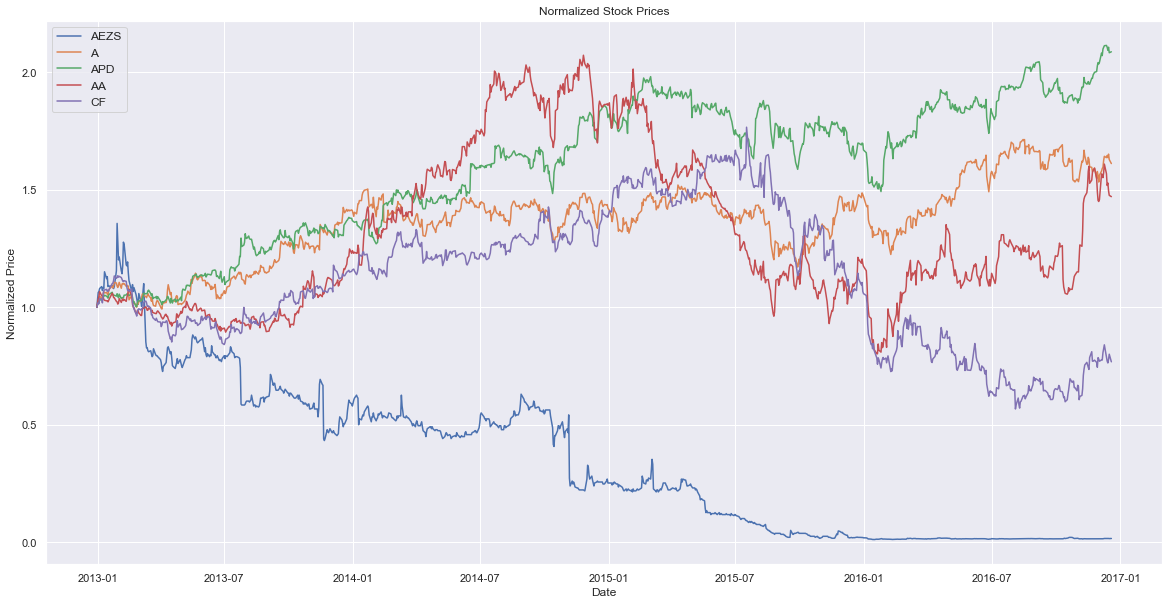

In [246]:
plt.figure(figsize=(20,10))
plt.plot((data/data.loc["2012-12-31"])['AEZS'], label='AEZS')
plt.plot((data/data.loc["2012-12-31"])['A'], label='A')
plt.plot((data/data.loc["2012-12-31"])['APD'], label='APD')
plt.plot((data/data.loc["2012-12-31"])['AA'], label='AA')
plt.plot((data/data.loc["2012-12-31"])['CF'], label='CF')
plt.title('Normalized Stock Prices')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Normalized Price')

## (a) Compute the portfolio matrix W=[w1,w2,…,w10]  and print it.

In [247]:
def mu(data):
    return data.mean().values

In [248]:
def Sigma(data):
    return data.cov().values

In [249]:
def Shrinkage_Sigma(data):
    shrinkage_sigma = LedoitWolf().fit(data)
    return shrinkage_sigma.covariance_

In [250]:
def Robust_Sigma(data):
    robust_sigma = MinCovDet().fit(data)
    return robust_sigma.covariance_

In [251]:
def get_mu_and_Sigma_log2lin(mu, Sigma):
    N = np.shape(Sigma)[0]
    mu_ = np.exp(mu + 0.5*np.diag(Sigma)) - 1
    Sigma_ = np.empty((N, N))
    for ii in range(N):
        for jj in range(N):
            Sigma_[ii, jj] = np.exp(mu[ii] + mu[jj] + 0.5*(Sigma[ii, ii]+Sigma[jj, jj])) * (np.exp(Sigma[ii, jj])-1)
    
    return mu, Sigma_

In [252]:
# create function for EWP
def EWP(Sigma):    
    N = Sigma.shape[0]
    w_EWP = np.ones(N) / N
    return w_EWP

In [253]:
# create function for GMVP
def GMVP(Sigma):
    w = cp.Variable(len(Sigma))
    variance = cp.quad_form(w, Sigma)
    objective = cp.Minimize(variance)
    constraint_1 = w >= 0
    constraint_2 = cp.sum(w) == 1
    problem = cp.Problem(objective, constraints = [constraint_1, constraint_2]) 
    
    problem.solve()
    return w.value

In [254]:
from scipy.optimize import minimize, LinearConstraint

def MDP(Sigma):
    N = Sigma.shape[0]
    Diag_sigma = np.sqrt(np.diag(Sigma))
    # define the nonconvex objective function
    def fn_DR(w, Diag_sigma, Sigma):
        x = w.reshape((-1, 1)) 
        return ((w @ Diag_sigma)/np.sqrt(x.T @ Sigma @ x))[0]

    # initial point
    w0 = np.ones(N)/N

    # define lower bounds for inequality constraints
    ub = np.inf * np.ones(N)
    lb = np.zeros(N)
    A = np.eye(N)
    ineq_lc = LinearConstraint(A=A, lb=lb, ub=ub)

    # define equality constraints
    eq_lc = LinearConstraint(A=np.ones(N), lb=1, ub=1)

    # call solver
    res = minimize(lambda x, *args: -fn_DR(x, *args), w0, args=(Diag_sigma, Sigma), constraints=[ineq_lc, eq_lc])
    w_MDP = res.x
    return w_MDP

In [255]:
def MDCP(Sigma):
    C = np.diag(1/np.sqrt(np.diag(Sigma))) @ Sigma @ np.diag(1/np.sqrt(np.diag(Sigma)))
    return GMVP(Sigma=C)

In [256]:
# create function for IVP
def IVP(Sigma):
    sigma2 = np.diag(Sigma)
    w_IVP = 1/np.sqrt(sigma2)
    w_IVP = w_IVP/np.sum(w_IVP)
    return w_IVP

In [257]:
# create function for RPP
def RPP(Sigma,b):
    N = Sigma.shape[0]
    x0 = np.ones(N)/N

    # function definition
    def fn_convex(x, Sigma, b):
        return(0.5 * x.T @ Sigma @ x - np.sum(b * np.log(x)))

    # optimize with general-purpose solver
    result = sco.minimize(fn_convex, x0=x0, args=(Sigma, b), method='BFGS')
    x_convex = result.x
    # normalize each column
    w_RPP_convex = x_convex/np.sum(x_convex)
    return w_RPP_convex

In [258]:
slices = np.arange(0,1001,100)

w_matrix_EWP = np.zeros(shape=(10,5))
w_matrix_GMVP = np.zeros(shape=(10,5))
w_matrix_MDP = np.zeros(shape=(10,5))
w_matrix_MDCP = np.zeros(shape=(10,5))
w_matrix_IVP = np.zeros(shape=(10,5))
w_matrix_RPP = np.zeros(shape=(10,5))

Sigma_lin_matrix = np.zeros(shape=(10,5,5))

# 1st date_slice
w_matrix_EWP[:] = np.ones(5)/5
w_matrix_GMVP[0] = np.ones(5)/5
w_matrix_MDP[0] = np.ones(5)/5
w_matrix_MDCP[0] = np.ones(5)/5
w_matrix_IVP[0] = np.ones(5)/5
w_matrix_RPP[0] = np.ones(5)/5


# 2nd - 10st date_slices
for i in range(1,10):
    
    
    mu_log = mu(data_return_log[slices[i-1]:slices[i]])
    Sigma_log = Sigma(data_return_log[slices[i-1]:slices[i]])

    mu_lin, Sigma_lin = get_mu_and_Sigma_log2lin(mu_log, Sigma_log)

    # this function can now be used as
    w_EWP = EWP(Sigma_lin)
    w_matrix_EWP[i] = w_EWP
    w_matrix_EWP
    
    w_GMVP = GMVP(Sigma_lin)
    w_matrix_GMVP[i] = w_GMVP
    w_matrix_GMVP
    
    w_MDP = MDP(Sigma_lin)
    w_matrix_MDP[i] = w_MDP
    w_matrix_MDP
    
    w_MDCP = MDCP(Sigma_lin)
    w_matrix_MDCP[i] = w_MDCP
    w_matrix_MDCP
    
    w_IVP = IVP(Sigma_lin)
    w_matrix_IVP[i] = w_IVP
    w_matrix_IVP
    
    w_RPP = RPP(Sigma_lin, [1/5 for i in range(5)])
    w_matrix_RPP[i] = w_RPP
    w_matrix_RPP
    

for i in range(0,10):
    mu_log = mu(data_return_log[slices[i]:slices[i+1]])
    Sigma_log = Sigma(data_return_log[slices[i]:slices[i+1]])

    mu_lin, Sigma_lin = get_mu_and_Sigma_log2lin(mu_log, Sigma_log)
    Sigma_lin_matrix[i] = Sigma_lin
    

In [259]:
EWP_wide = pd.DataFrame(w_matrix_EWP)
GMVP_wide = pd.DataFrame(w_matrix_GMVP)
MDP_wide = pd.DataFrame(w_matrix_MDP)
MDCP_wide = pd.DataFrame(w_matrix_MDCP)
IVP_wide = pd.DataFrame(w_matrix_IVP)
RPP_wide = pd.DataFrame(w_matrix_RPP)

EWP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']
GMVP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']
MDP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']
MDCP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']
IVP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']
RPP_wide.columns =['AEZS', 'A', 'APD', 'AA', 'CF']

EWP_wide.index = np.arange(1,11)
GMVP_wide.index = np.arange(1,11)
MDP_wide.index = np.arange(1,11)
MDCP_wide.index = np.arange(1,11)
IVP_wide.index = np.arange(1,11)
RPP_wide.index = np.arange(1,11)

EWP_long = EWP_wide.unstack().reset_index() 
GMVP_long = GMVP_wide.unstack().reset_index() 
MDP_long = MDP_wide.unstack().reset_index() 
MDCP_long = MDCP_wide.unstack().reset_index() 
IVP_long = IVP_wide.unstack().reset_index() 
RPP_long = RPP_wide.unstack().reset_index() 

EWP_long.columns = ['stocks','slices','weights']
GMVP_long.columns = ['stocks','slices','weights']
MDP_long.columns = ['stocks','slices','weights']
MDCP_long.columns = ['stocks','slices','weights']
IVP_long.columns = ['stocks','slices','weights']
RPP_long.columns = ['stocks','slices','weights']


## (b) Create a grouped bar chart of the portfolio matrix like the following figure

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

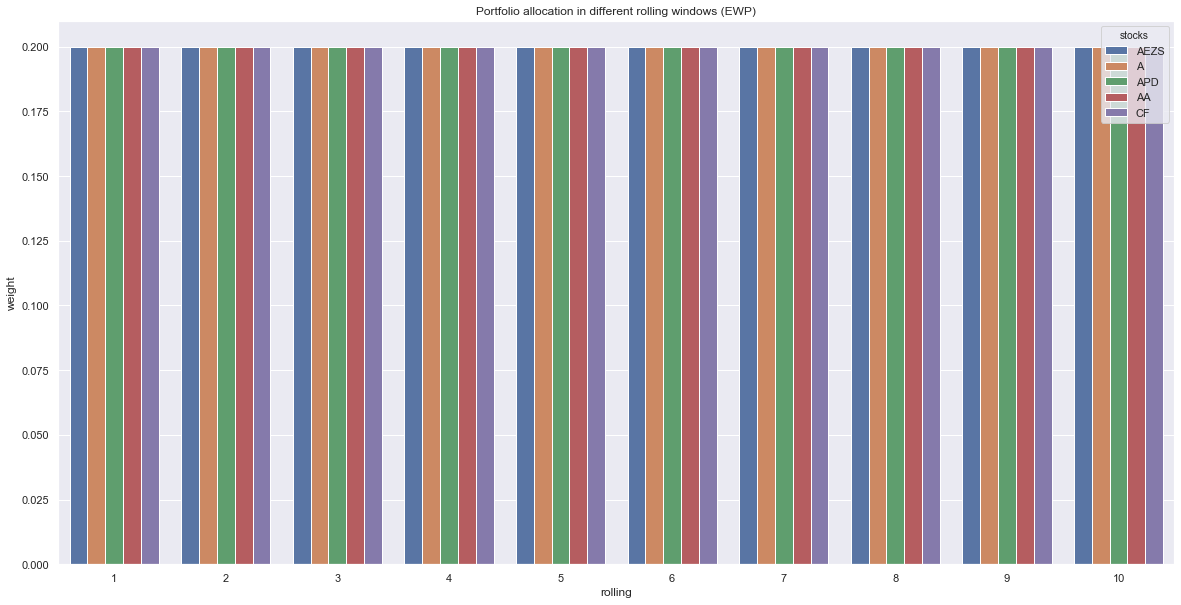

In [260]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=EWP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (EWP)")
ax.set(xlabel='rolling', ylabel='weight')

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

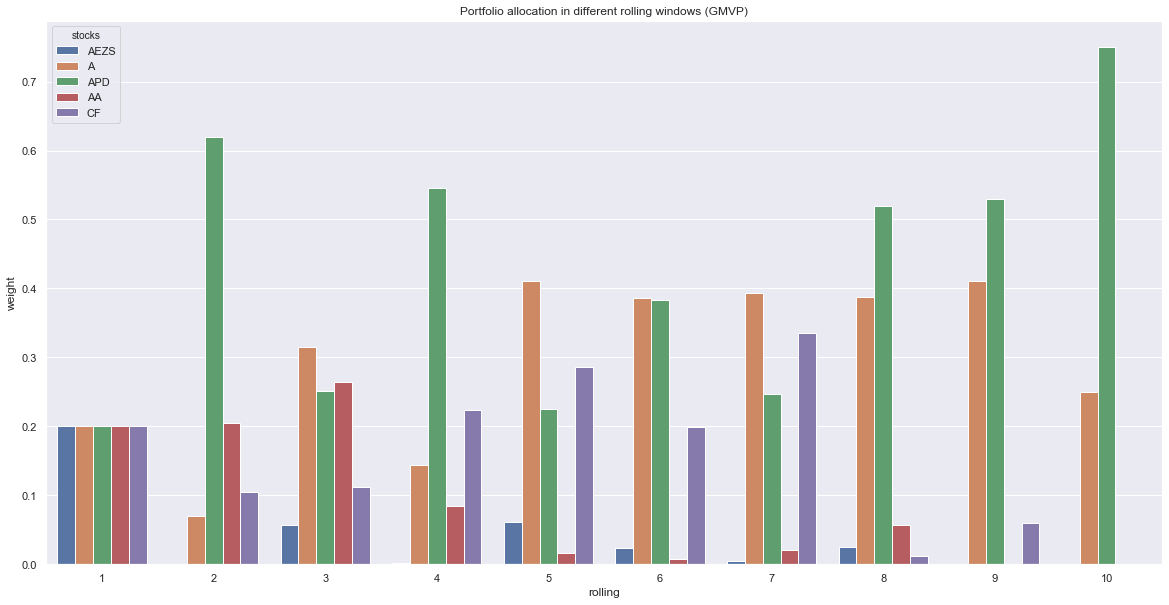

In [261]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=GMVP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (GMVP)")
ax.set(xlabel='rolling', ylabel='weight')

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

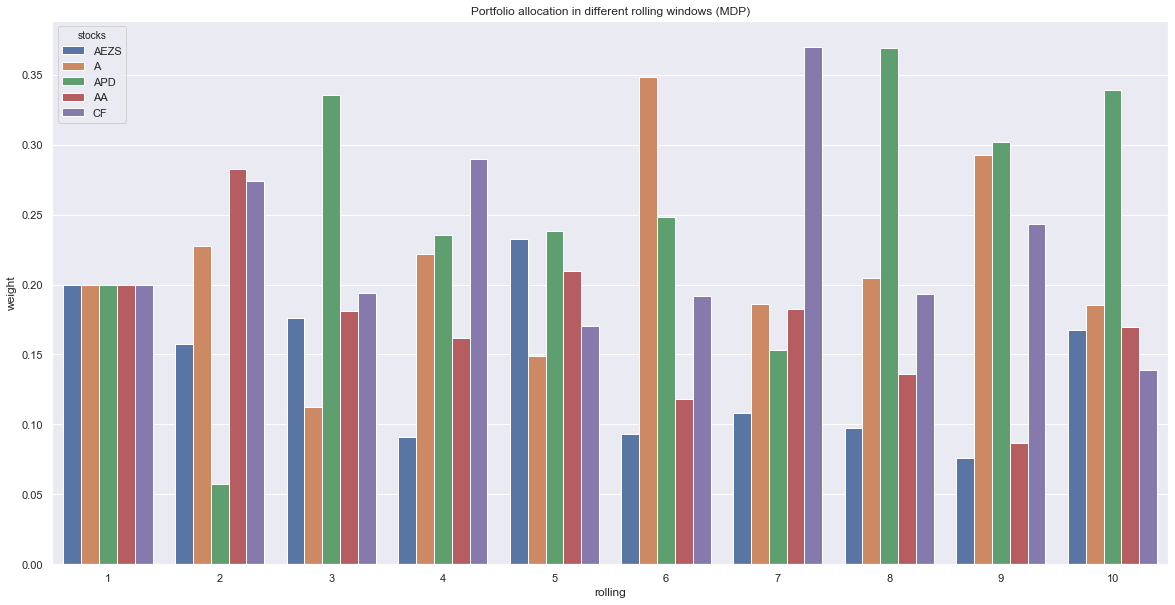

In [262]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=MDP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (MDP)")
ax.set(xlabel='rolling', ylabel='weight')

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

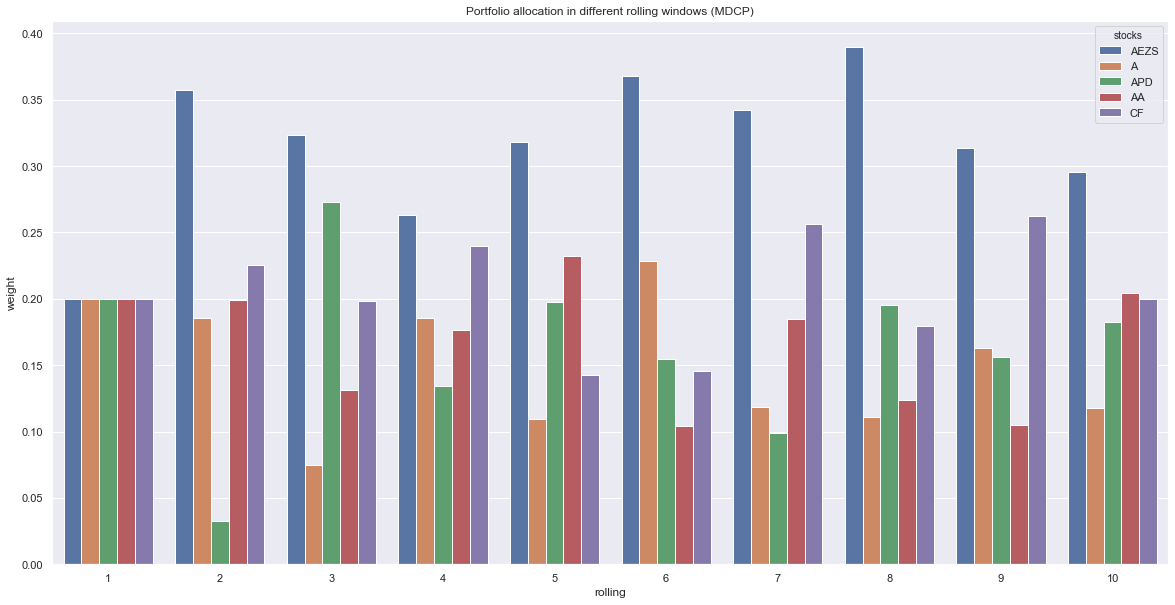

In [263]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=MDCP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (MDCP)")
ax.set(xlabel='rolling', ylabel='weight')

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

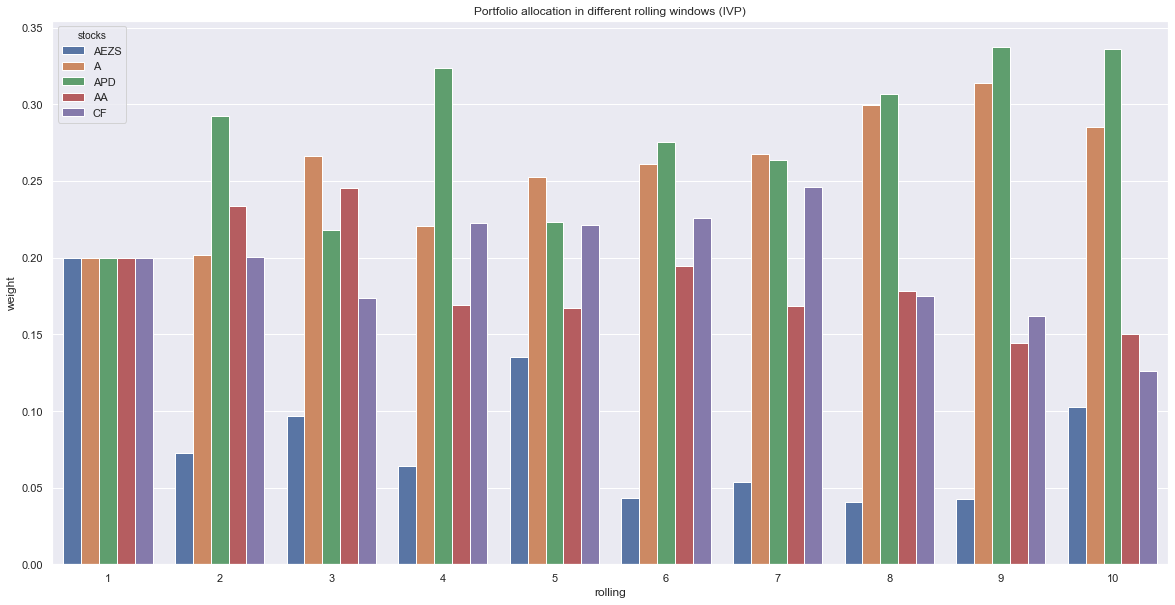

In [264]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=IVP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (IVP)")
ax.set(xlabel='rolling', ylabel='weight')

[Text(0, 0.5, 'weight'), Text(0.5, 0, 'rolling')]

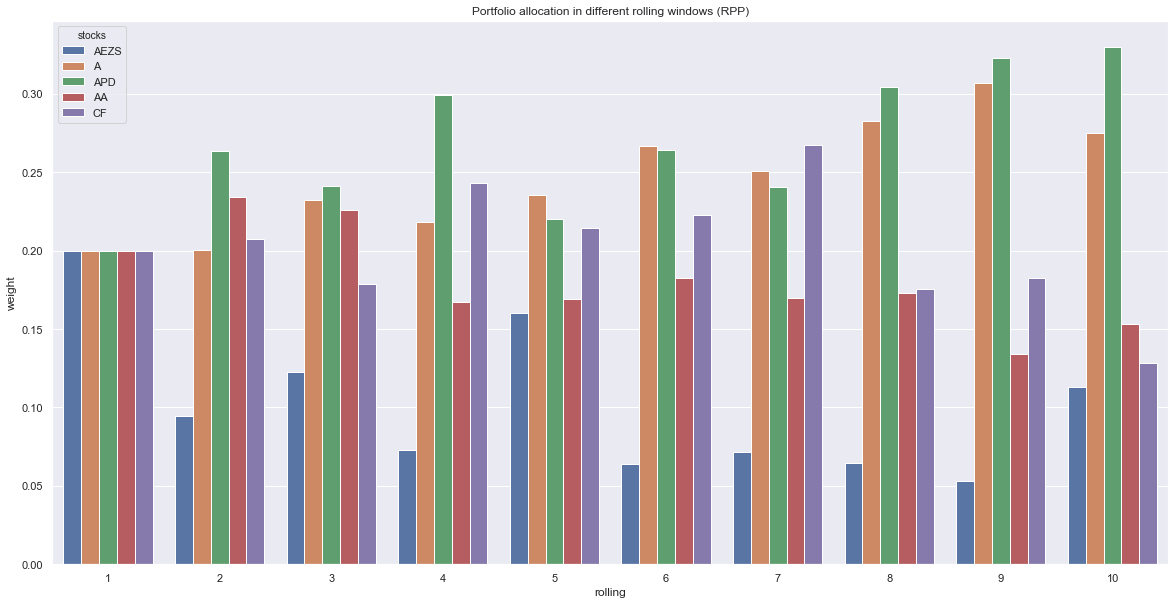

In [265]:
# plot to compare the allocations
sns.set(rc={'figure.figsize':(20,10)})

ax = sns.barplot(data=RPP_long, x='slices', y='weights', hue='stocks')
ax.set_title("Portfolio allocation in different rolling windows (RPP)")
ax.set(xlabel='rolling', ylabel='weight')

# Relative risk contributions

#### In-Sample

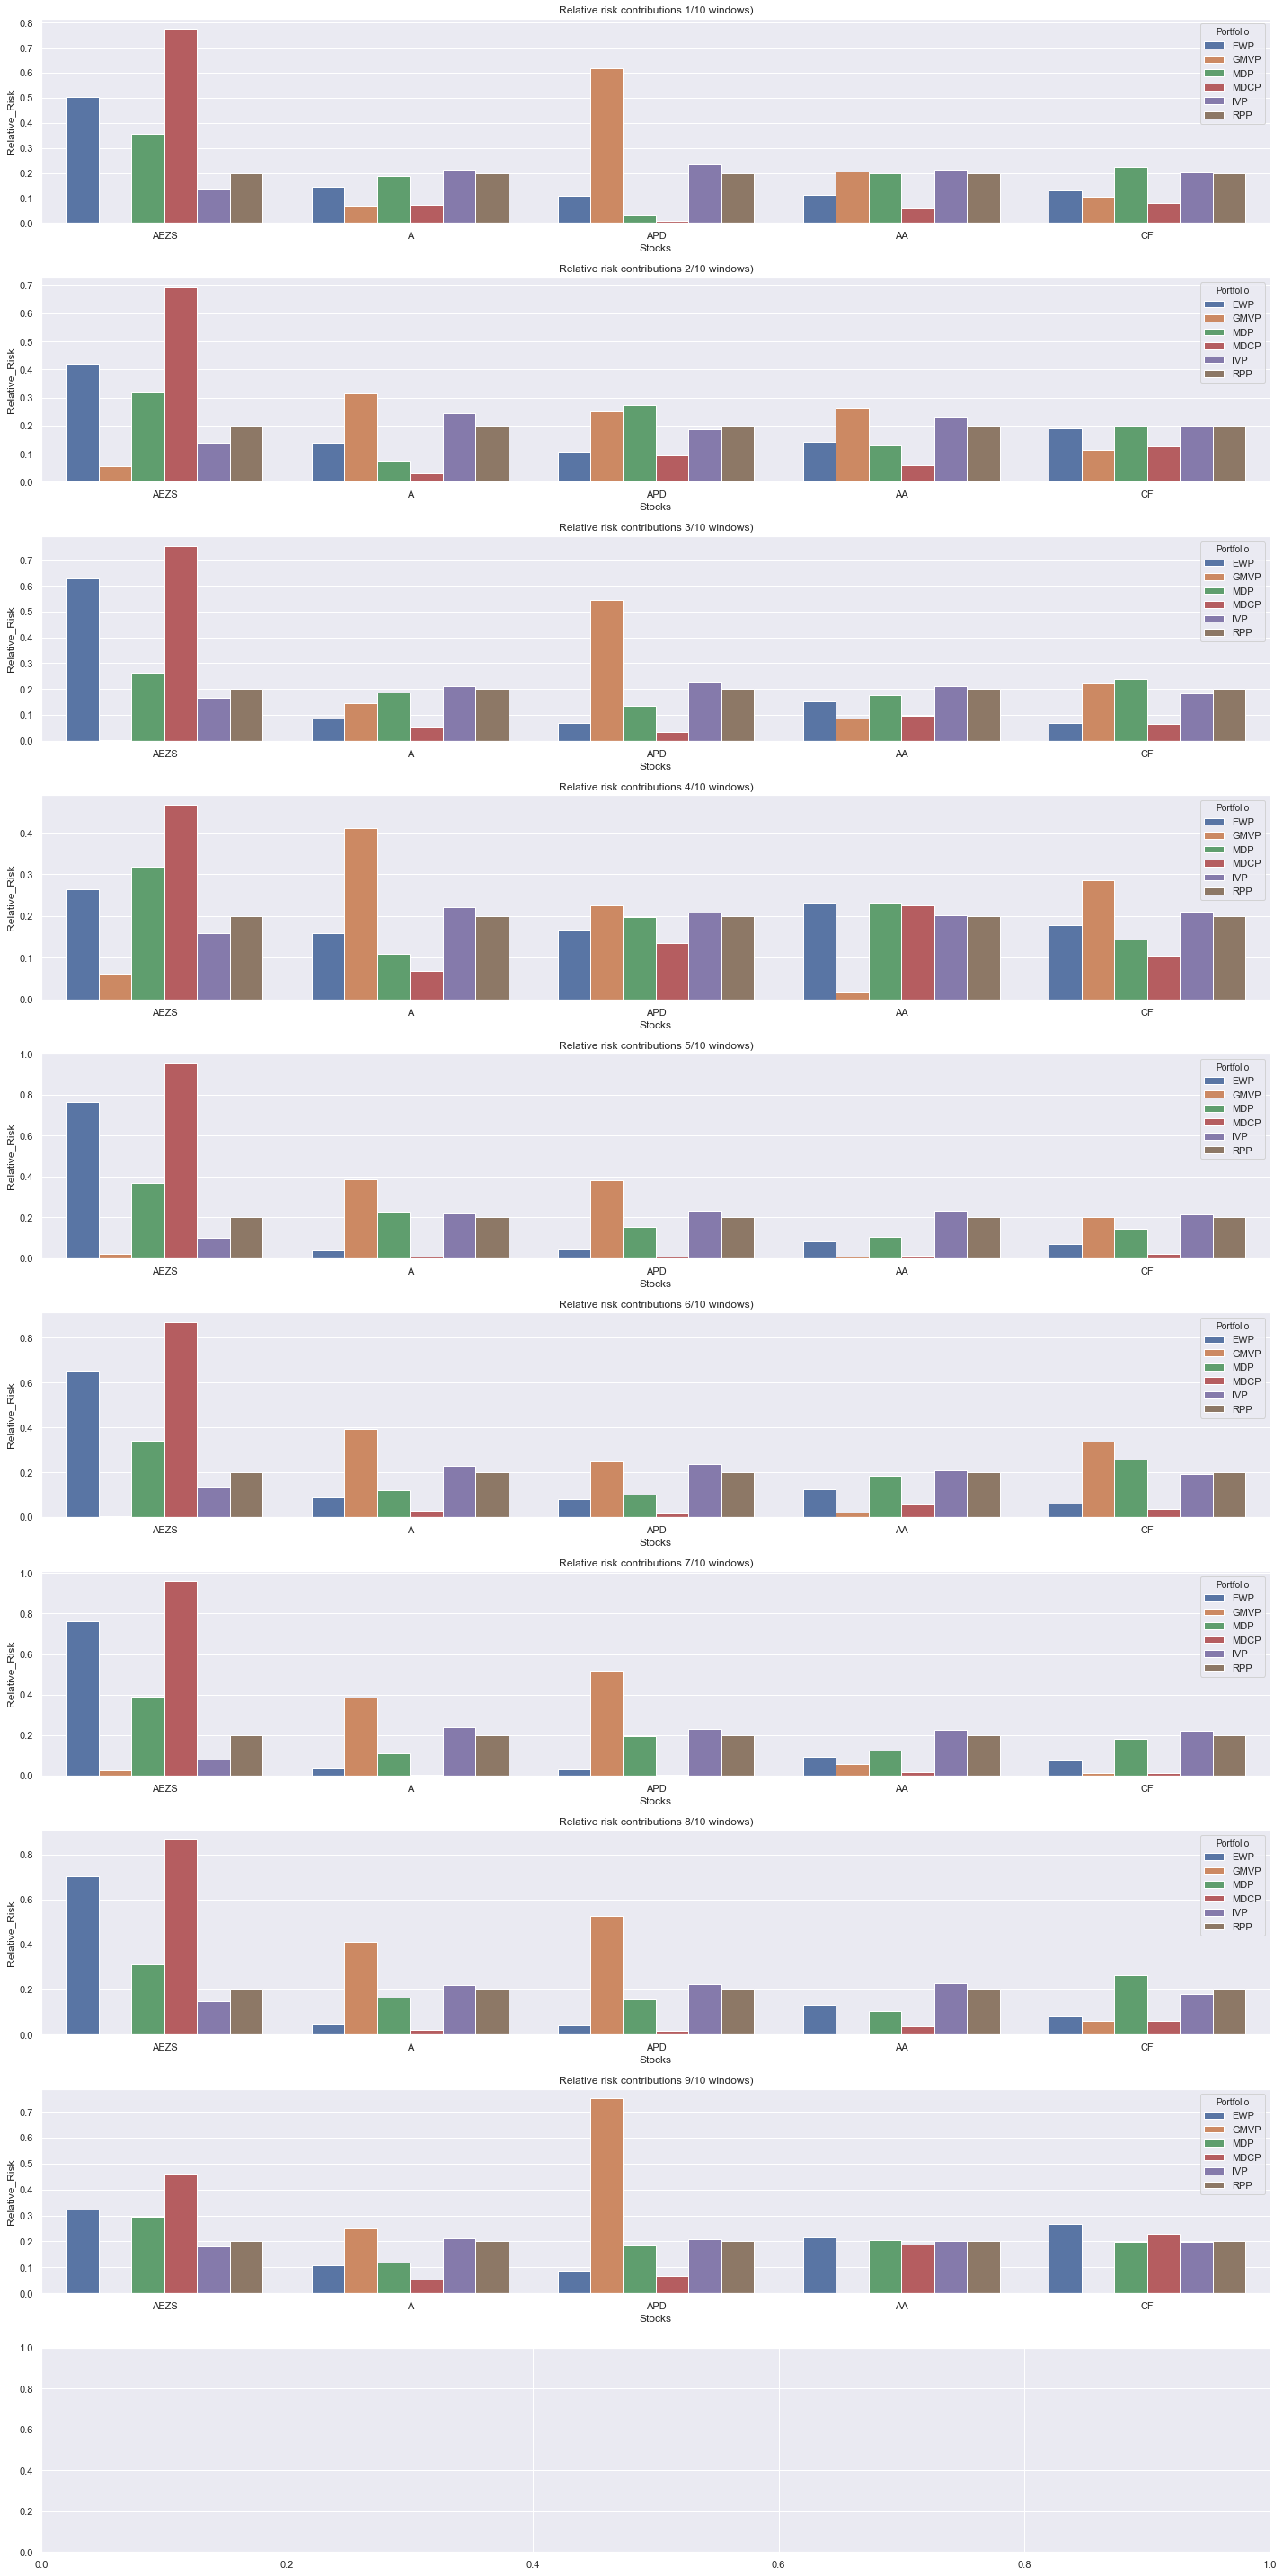

In [266]:
# compute risk contributions
sns.set(rc={'figure.figsize':(20,40)})
fig, axes = plt.subplots(10, 1)


for i in range(0,9):
    Total_Risk = pd.DataFrame(np.asarray([w_matrix_EWP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_EWP[i+1]),
                                        w_matrix_GMVP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_GMVP[i+1]),
                                        w_matrix_MDP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_MDP[i+1]),
                                        w_matrix_MDCP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_MDCP[i+1]),
                                        w_matrix_IVP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_IVP[i+1]),
                                        w_matrix_RPP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_RPP[i+1])]).T,
                            columns=['EWP', 'GMVP', 'MDP', 'MDCP', 'IVP', 'RPP'],
                            index=data.columns)

    Relative_risk = Total_Risk / Total_Risk.sum()
    # plt.bar(Relative_risk, rot=0, title="Relative risk contributions", width=1)
    # Relative_risk.plot.bar(rot=0, title="Relative risk contributions", width=1)

    Relative_risk_long = Relative_risk.unstack().reset_index() 
    Relative_risk_long.columns = ['Portfolio','Stocks','Relative_Risk']

    # plot to compare the allocations
    
    sns.barplot(ax=axes[i], data=Relative_risk_long, x='Stocks', y='Relative_Risk', hue='Portfolio')
    axes[i].set_title('Relative risk contributions ' + str(i+1) + '/10 windows)')
    axes[i].set(xlabel='Stocks', ylabel='Relative_Risk')

fig.tight_layout()
plt.show()

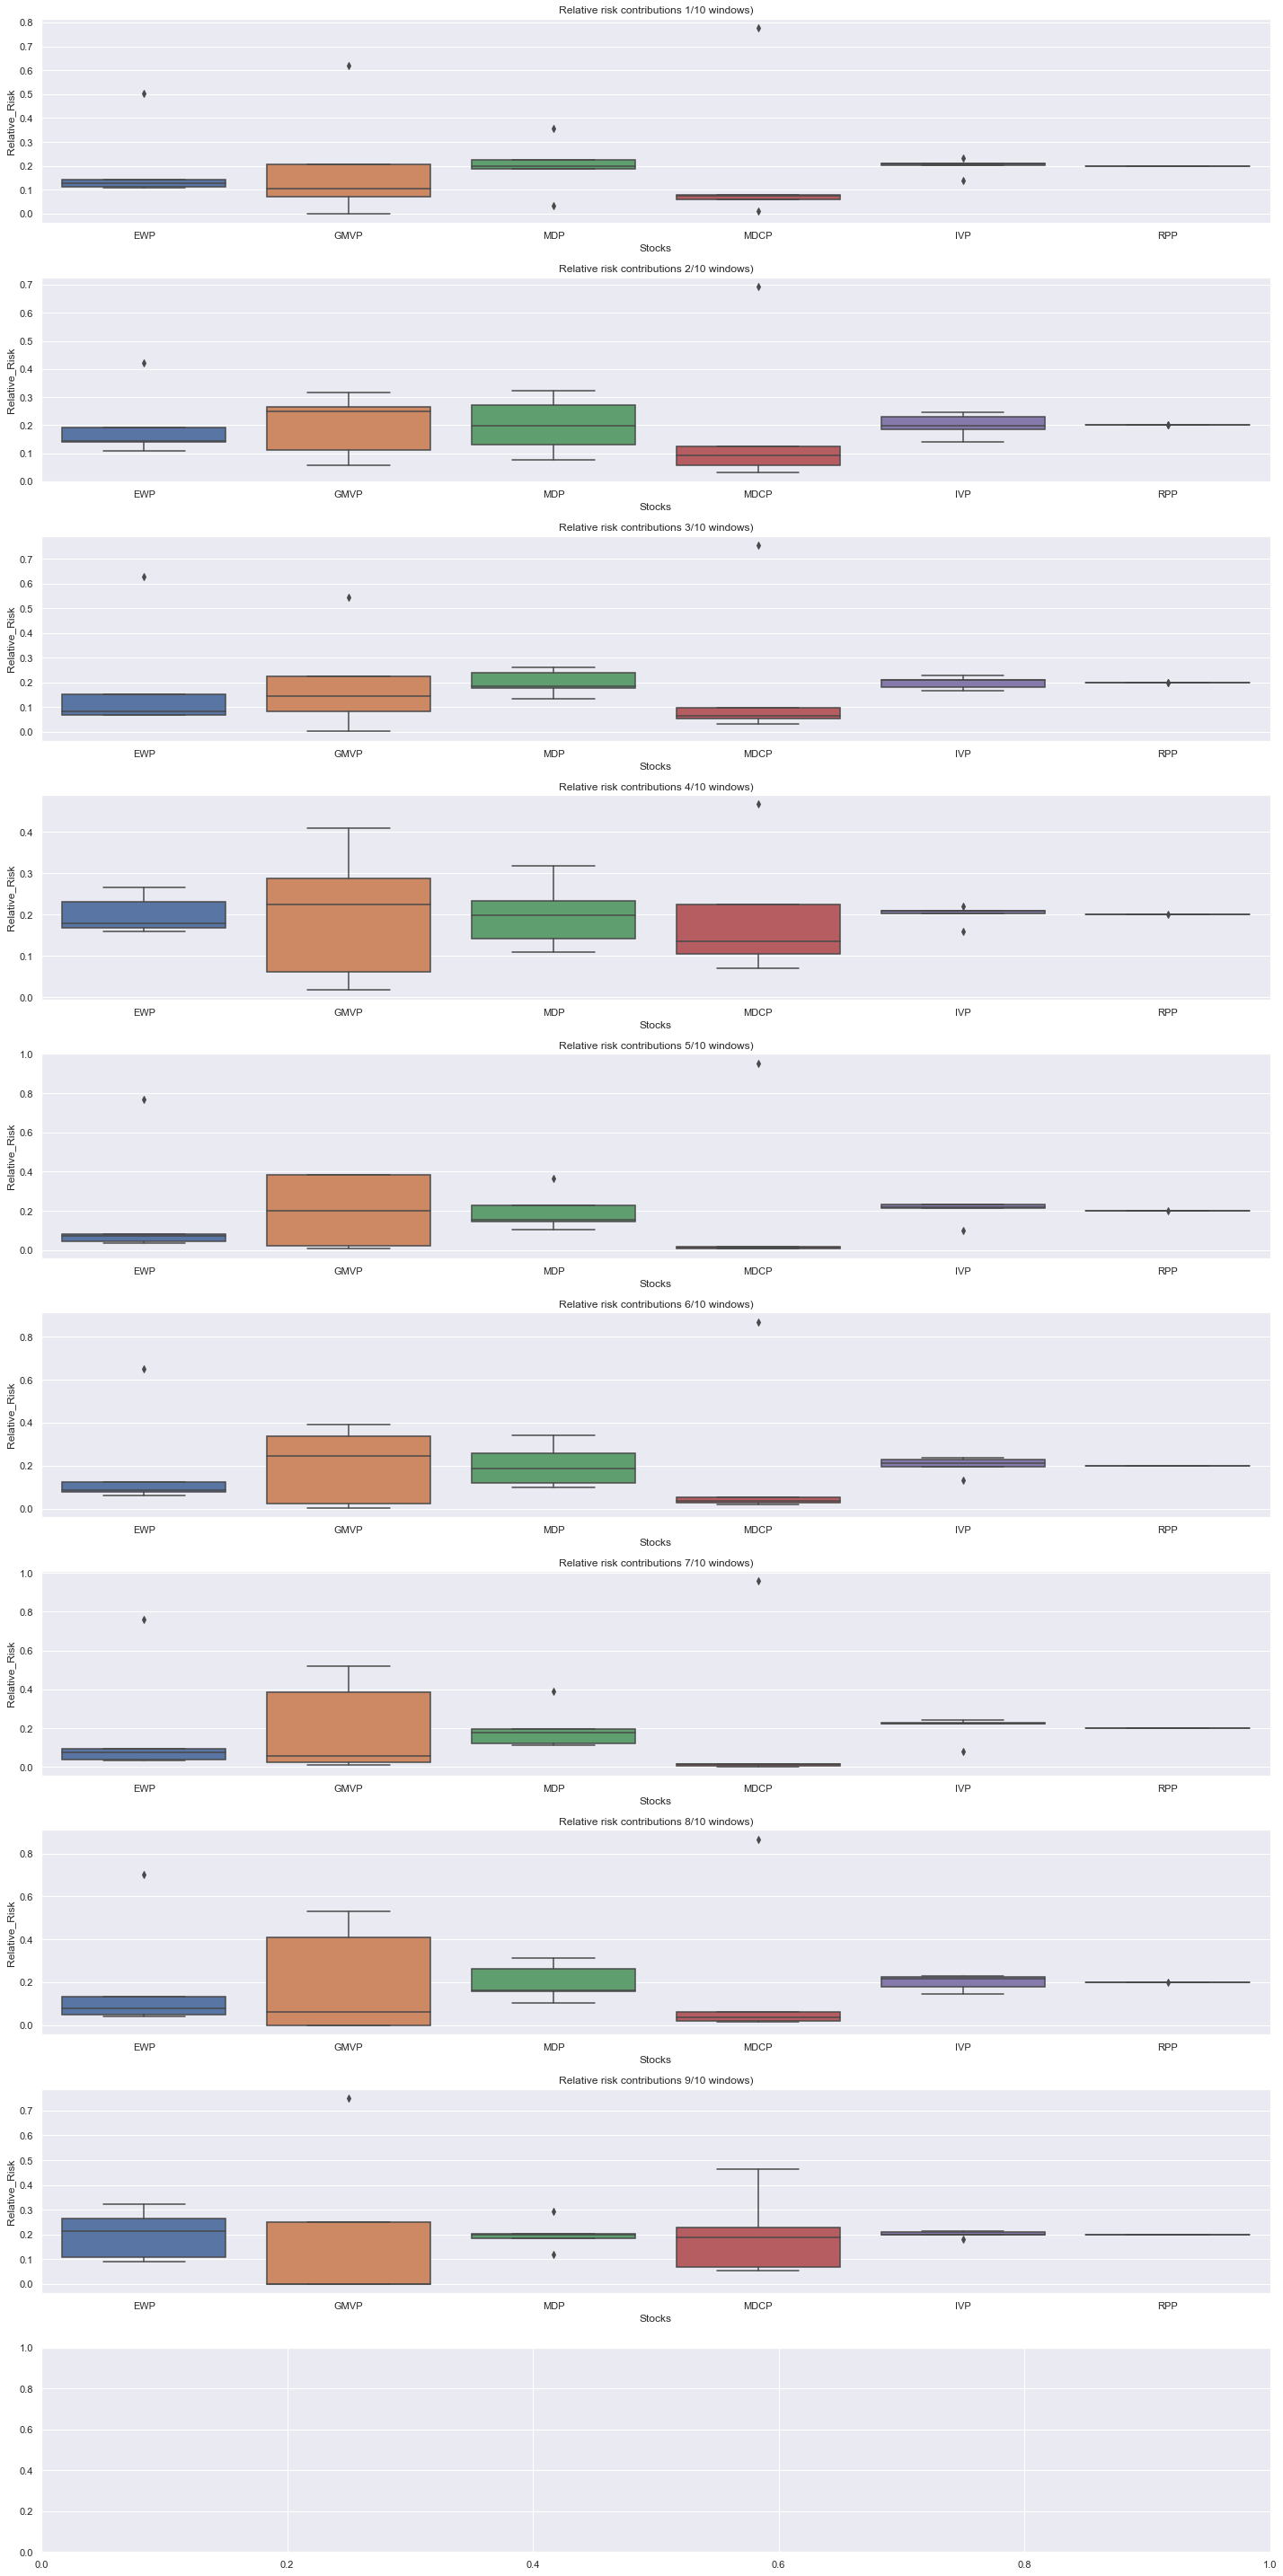

In [267]:
# compute risk contributions
sns.set(rc={'figure.figsize':(20,40)})
fig, axes = plt.subplots(10, 1)


for i in range(0,9):
    Total_Risk = pd.DataFrame(np.asarray([w_matrix_EWP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_EWP[i+1]),
                                        w_matrix_GMVP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_GMVP[i+1]),
                                        w_matrix_MDP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_MDP[i+1]),
                                        w_matrix_MDCP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_MDCP[i+1]),
                                        w_matrix_IVP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_IVP[i+1]),
                                        w_matrix_RPP[i+1] * (Sigma_lin_matrix[i] @ w_matrix_RPP[i+1])]).T,
                            columns=['EWP', 'GMVP', 'MDP', 'MDCP', 'IVP', 'RPP'],
                            index=data.columns)

    Relative_risk = Total_Risk / Total_Risk.sum()
    # plt.bar(Relative_risk, rot=0, title="Relative risk contributions", width=1)
    # Relative_risk.plot.bar(rot=0, title="Relative risk contributions", width=1)

    Relative_risk_long = Relative_risk.unstack().reset_index() 
    Relative_risk_long.columns = ['Portfolio','Stocks','Relative_Risk']

    # plot to compare the allocations
    
    sns.boxplot(ax = axes[i], data=Relative_risk)
    axes[i].set_title('Relative risk contributions ' + str(i+1) + '/10 windows)')
    axes[i].set(xlabel='Stocks', ylabel='Relative_Risk')

fig.tight_layout()
plt.show()

#### Out-Sample

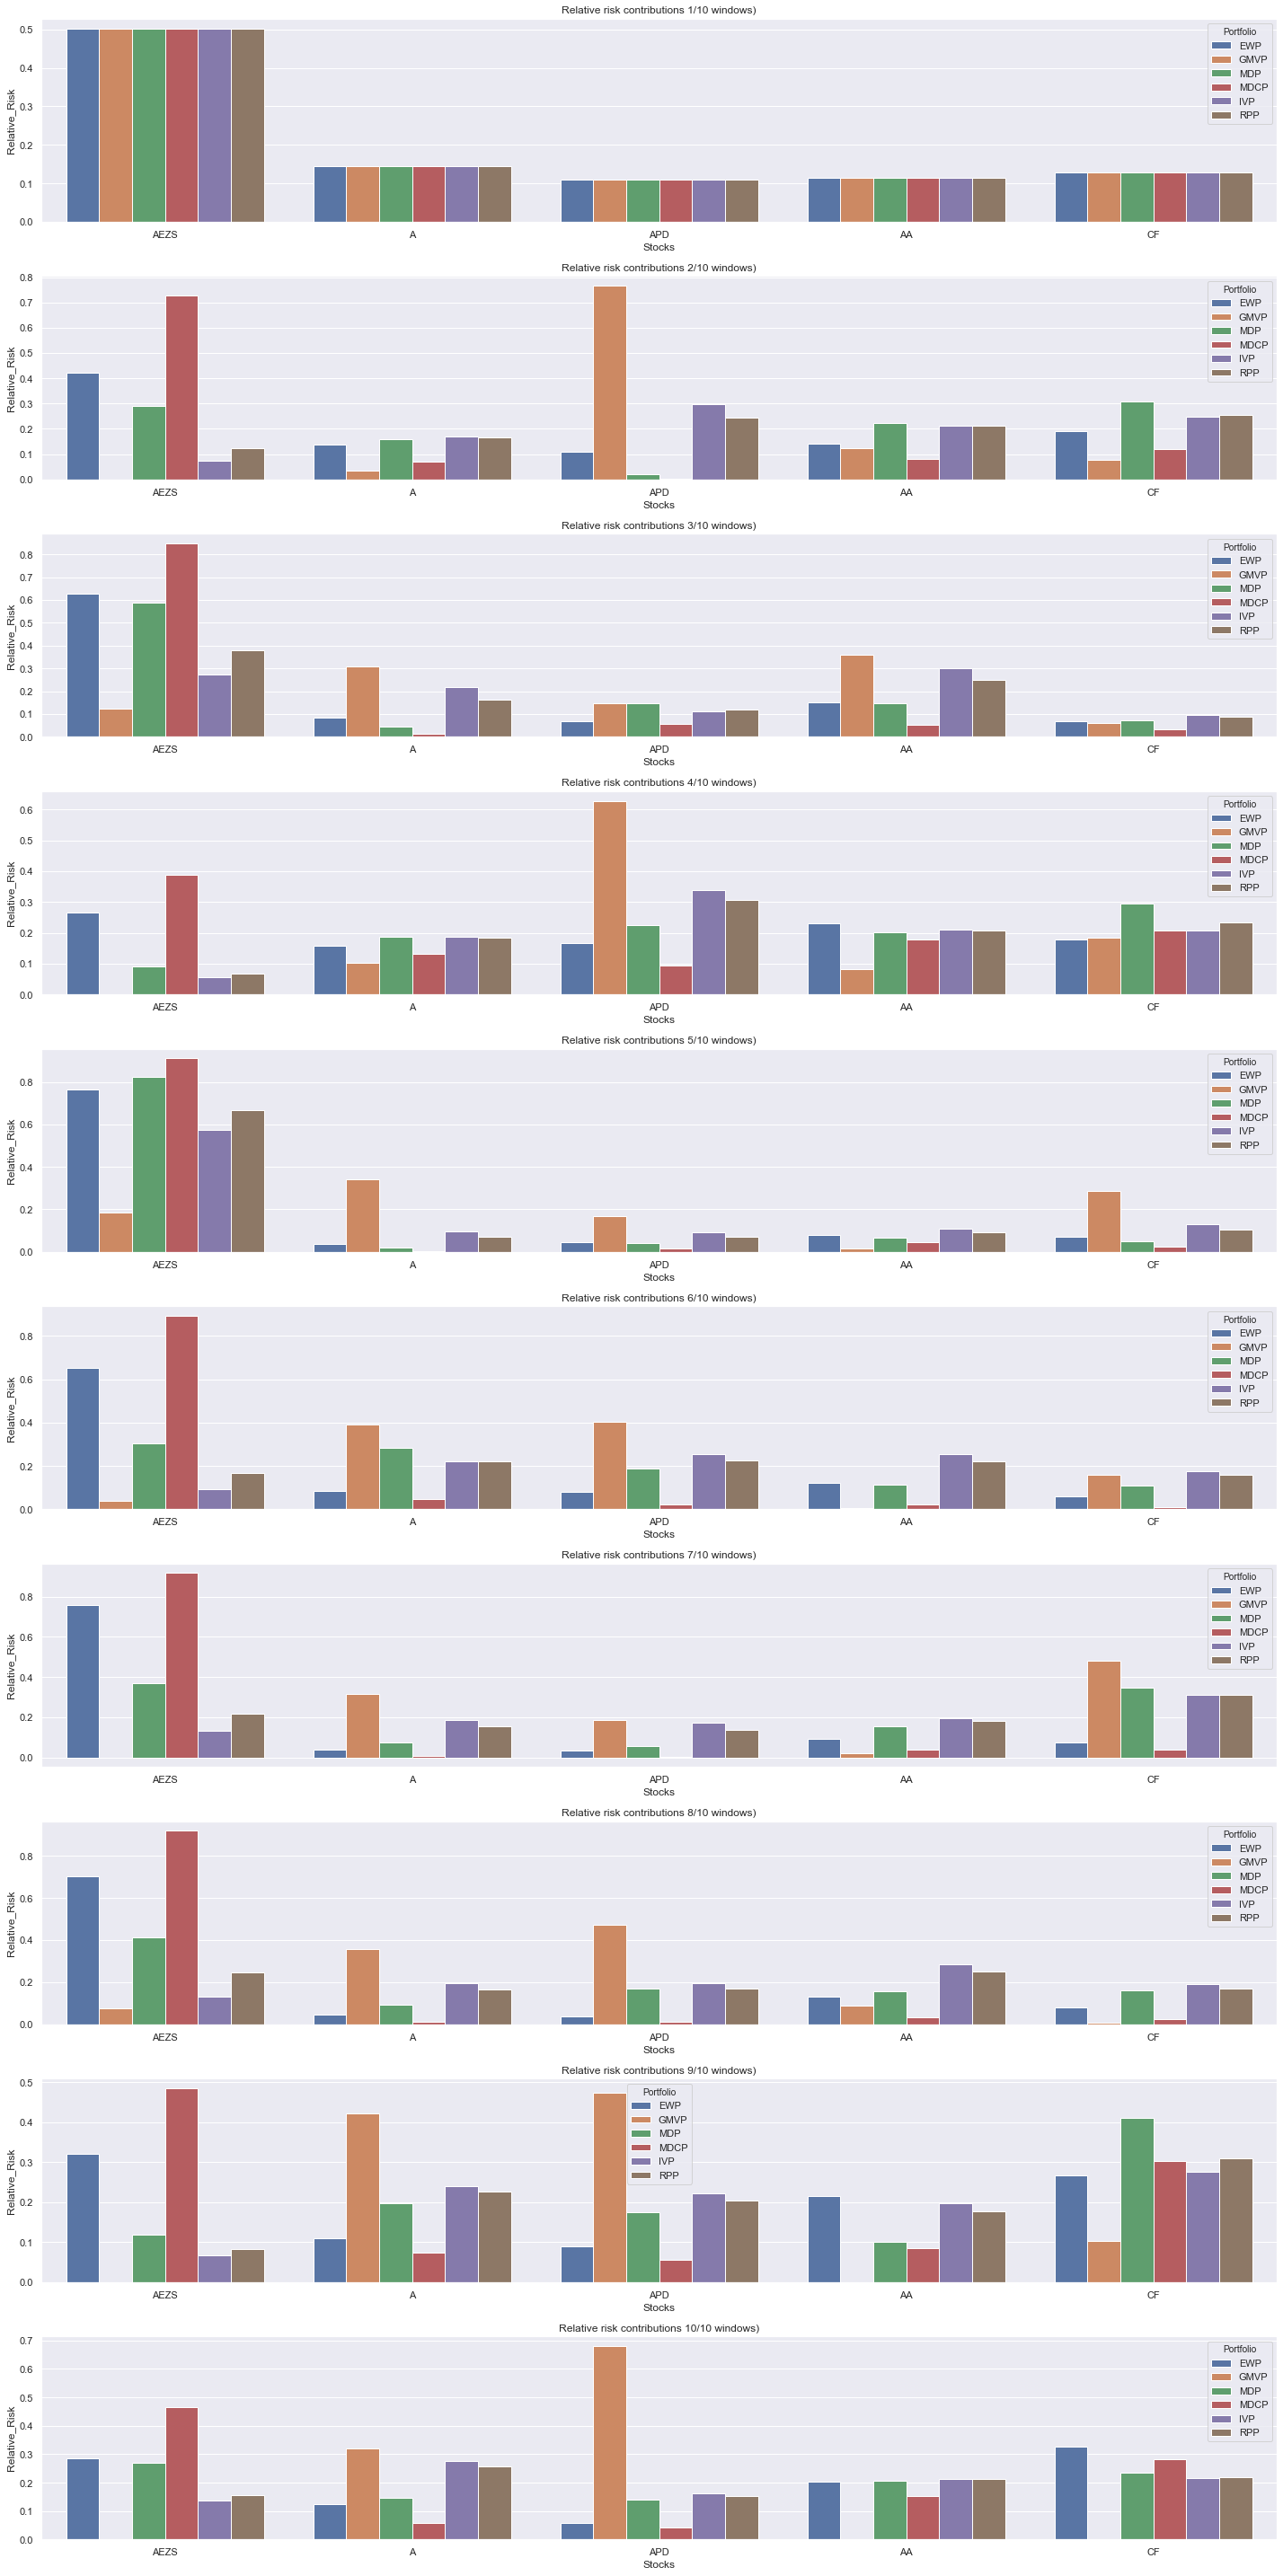

In [268]:
# compute risk contributions
sns.set(rc={'figure.figsize':(20,40)})
fig, axes = plt.subplots(10, 1)


for i in range(10):
    Total_Risk = pd.DataFrame(np.asarray([w_matrix_EWP[i] * (Sigma_lin_matrix[i] @ w_matrix_EWP[i]),
                                        w_matrix_GMVP[i] * (Sigma_lin_matrix[i] @ w_matrix_GMVP[i]),
                                        w_matrix_MDP[i] * (Sigma_lin_matrix[i] @ w_matrix_MDP[i]),
                                        w_matrix_MDCP[i] * (Sigma_lin_matrix[i] @ w_matrix_MDCP[i]),
                                        w_matrix_IVP[i] * (Sigma_lin_matrix[i] @ w_matrix_IVP[i]),
                                        w_matrix_RPP[i] * (Sigma_lin_matrix[i] @ w_matrix_RPP[i])]).T,
                            columns=['EWP', 'GMVP', 'MDP', 'MDCP', 'IVP', 'RPP'],
                            index=data.columns)

    Relative_risk = Total_Risk / Total_Risk.sum()
    # plt.bar(Relative_risk, rot=0, title="Relative risk contributions", width=1)
    # Relative_risk.plot.bar(rot=0, title="Relative risk contributions", width=1)

    Relative_risk_long = Relative_risk.unstack().reset_index() 
    Relative_risk_long.columns = ['Portfolio','Stocks','Relative_Risk']

    # plot to compare the allocations
    
    sns.barplot(ax=axes[i], data=Relative_risk_long, x='Stocks', y='Relative_Risk', hue='Portfolio')
    axes[i].set_title('Relative risk contributions ' + str(i+1) + '/10 windows)')
    axes[i].set(xlabel='Stocks', ylabel='Relative_Risk')

fig.tight_layout()
plt.show()

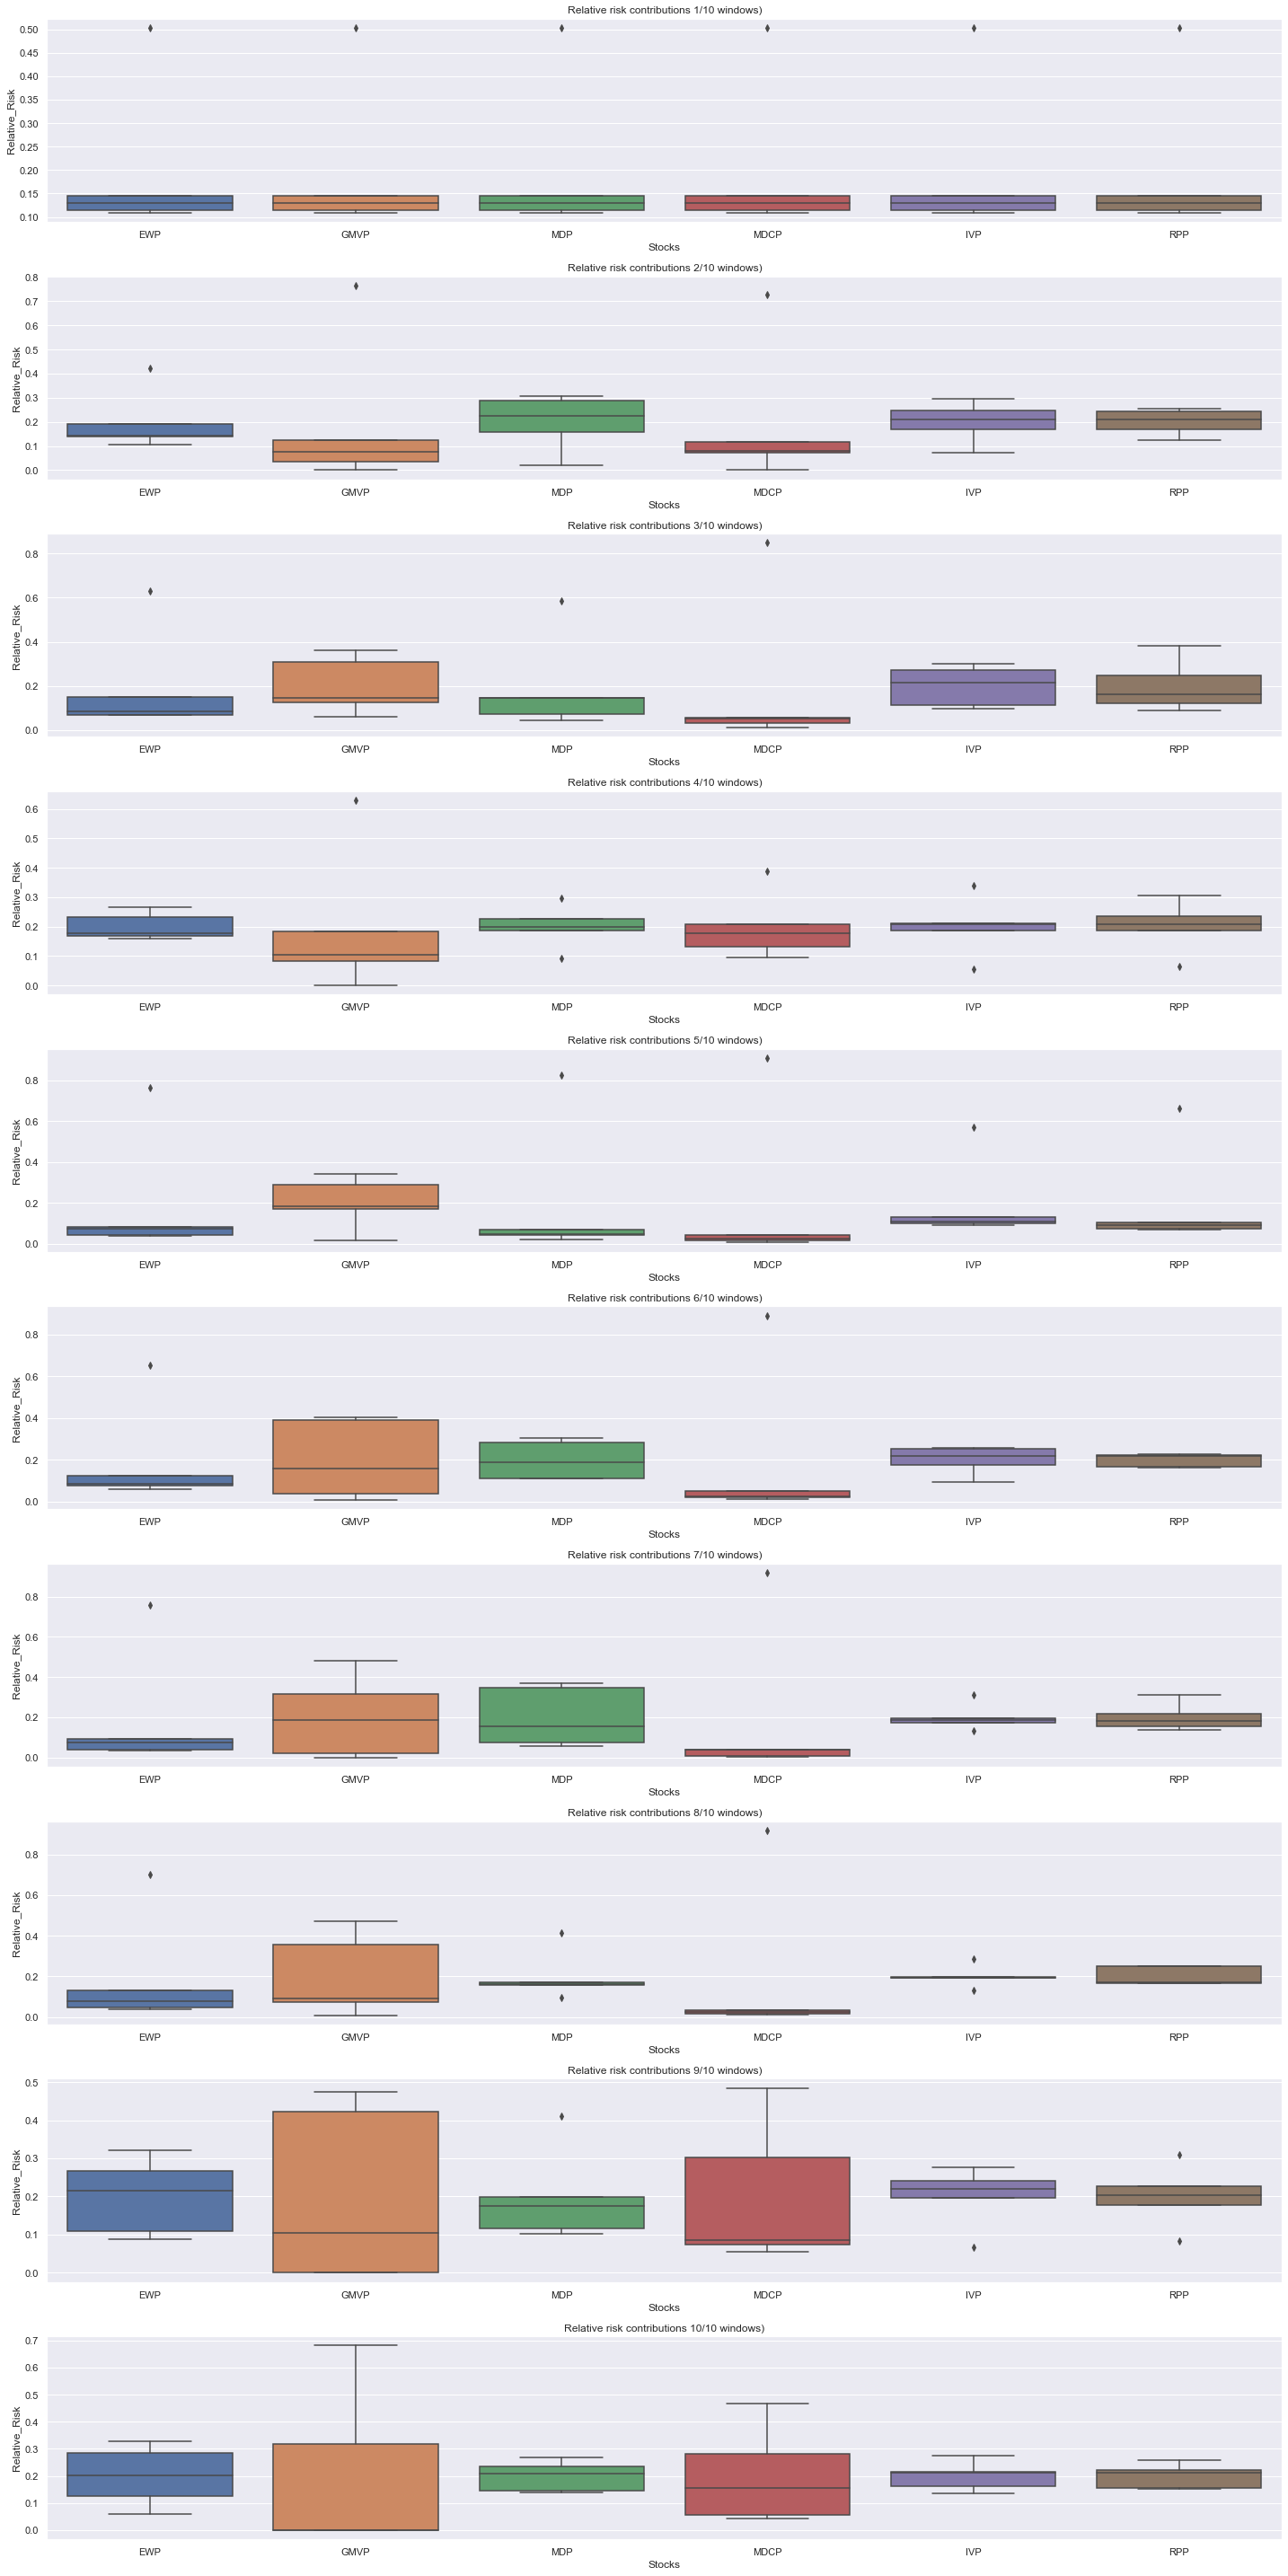

In [269]:
# compute risk contributions
sns.set(rc={'figure.figsize':(20,40)})
fig, axes = plt.subplots(10, 1)


for i in range(10):
    Total_Risk = pd.DataFrame(np.asarray([w_matrix_EWP[i] * (Sigma_lin_matrix[i] @ w_matrix_EWP[i]),
                                        w_matrix_GMVP[i] * (Sigma_lin_matrix[i] @ w_matrix_GMVP[i]),
                                        w_matrix_MDP[i] * (Sigma_lin_matrix[i] @ w_matrix_MDP[i]),
                                        w_matrix_MDCP[i] * (Sigma_lin_matrix[i] @ w_matrix_MDCP[i]),
                                        w_matrix_IVP[i] * (Sigma_lin_matrix[i] @ w_matrix_IVP[i]),
                                        w_matrix_RPP[i] * (Sigma_lin_matrix[i] @ w_matrix_RPP[i])]).T,
                            columns=['EWP', 'GMVP', 'MDP', 'MDCP', 'IVP', 'RPP'],
                            index=data.columns)

    Relative_risk = Total_Risk / Total_Risk.sum()
    # plt.bar(Relative_risk, rot=0, title="Relative risk contributions", width=1)
    # Relative_risk.plot.bar(rot=0, title="Relative risk contributions", width=1)

    Relative_risk_long = Relative_risk.unstack().reset_index() 
    Relative_risk_long.columns = ['Portfolio','Stocks','Relative_Risk']

    # plot to compare the allocations
    
    sns.boxplot(ax = axes[i], data=Relative_risk)
    axes[i].set_title('Relative risk contributions ' + str(i+1) + '/10 windows)')
    axes[i].set(xlabel='Stocks', ylabel='Relative_Risk')

fig.tight_layout()
plt.show()

## (c) Compute the simple return (not compounded) of GMVP in this backtest. Plot the return path compared with the EWP.

In [270]:
EWP_backtest = np.array([1])
GMVP_backtest = np.array([1])
MDP_backtest = np.array([1])
MDCP_backtest = np.array([1])
IVP_backtest = np.array([1])
RPP_backtest = np.array([1])

for i in range(1000):
    EWP_backtest = np.append(EWP_backtest, (EWP_backtest[-1] -1) + np.sum((1 * EWP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    GMVP_backtest = np.append(GMVP_backtest, (GMVP_backtest[-1] -1) + np.sum((1 * GMVP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    MDP_backtest = np.append(MDP_backtest, (MDP_backtest[-1] -1) + np.sum((1 * MDP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    MDCP_backtest = np.append(MDCP_backtest, (MDCP_backtest[-1] -1) + np.sum((1 * MDCP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    IVP_backtest = np.append(IVP_backtest, (IVP_backtest[-1] -1) + np.sum((1 * IVP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    RPP_backtest = np.append(RPP_backtest, (RPP_backtest[-1] -1) + np.sum((1 * RPP_wide.iloc[int(i/100)] * (1 + data_return_lin.iloc[i]))))
    
# EWP_backtest, GMVP_backtest, IVP_backtest, RPP_backtest

Text(0, 0.5, 'Normalized Return')

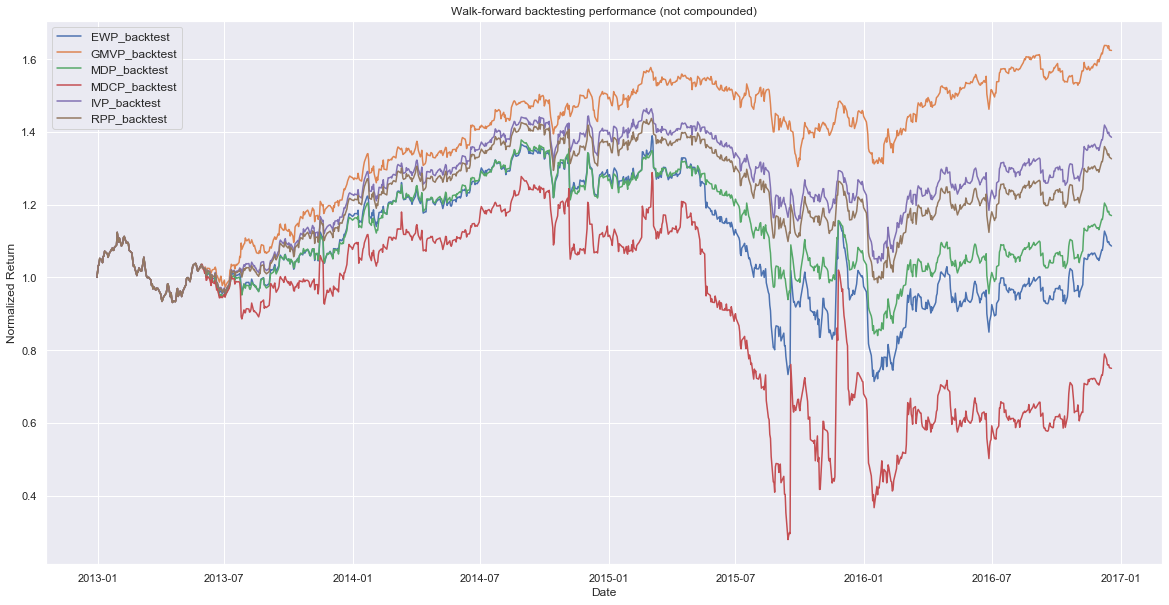

In [271]:
plt.figure(figsize=(20,10))

plt.plot(data.index, EWP_backtest, label='EWP_backtest')
plt.plot(data.index, GMVP_backtest, label='GMVP_backtest')
plt.plot(data.index, MDP_backtest, label='MDP_backtest')
plt.plot(data.index, MDCP_backtest, label='MDCP_backtest')
plt.plot(data.index, IVP_backtest, label='IVP_backtest')
plt.plot(data.index, RPP_backtest, label='RPP_backtest')

plt.legend(loc='upper left', fontsize=12)
plt.title('Walk-forward backtesting performance (not compounded)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')

In [272]:
EWP_return_log = np.diff(np.log(EWP_backtest))
GMVP_return_log = np.diff(np.log(GMVP_backtest))
MDP_return_log = np.diff(np.log(MDP_backtest))
MDCP_return_log = np.diff(np.log(MDCP_backtest))
IVP_return_log = np.diff(np.log(IVP_backtest))
RPP_return_log = np.diff(np.log(RPP_backtest))


In [273]:
print('The mean return of EWP_backtest: ', np.mean(EWP_return_log)*252)
print('The mean return of GMVP_backtest: ', np.mean(GMVP_return_log)*252)
print('The mean return of MDP_backtest: ', np.mean(MDP_return_log)*252)
print('The mean return of MDCP_backtest: ', np.mean(MDCP_return_log)*252)
print('The mean return of IVP_backtest: ', np.mean(IVP_return_log)*252)
print('The mean return of RPP_backtest: ', np.mean(RPP_return_log)*252)

The mean return of EWP_backtest:  0.020791955225549226
The mean return of GMVP_backtest:  0.1221291328613562
The mean return of MDP_backtest:  0.03950362846822808
The mean return of MDCP_backtest:  -0.07253026266485857
The mean return of IVP_backtest:  0.08208096603003597
The mean return of RPP_backtest:  0.07105684707770556


In [274]:
print('The volatility of EWP_backtest: ', np.std(EWP_return_log)*np.sqrt(252))
print('The volatility of GMVP_backtest: ', np.std(GMVP_return_log)*np.sqrt(252))
print('The volatility of MDP_backtest: ', np.std(MDP_return_log)*np.sqrt(252))
print('The volatility of MDCP_backtest: ', np.std(MDCP_return_log)*np.sqrt(252))
print('The volatility of IVP_backtest: ', np.std(IVP_return_log)*np.sqrt(252))
print('The volatility of RPP_backtest: ', np.std(RPP_return_log)*np.sqrt(252))

The volatility of EWP_backtest:  0.32403826809119696
The volatility of GMVP_backtest:  0.144775231186643
The volatility of MDP_backtest:  0.22818689806949163
The volatility of MDCP_backtest:  0.7802350433166365
The volatility of IVP_backtest:  0.17171836874843596
The volatility of RPP_backtest:  0.18487740007530737


In [275]:
print('The Sharpe ratio of EWP_backtest: ', np.mean(EWP_return_log)*np.sqrt(252)/np.std(EWP_return_log))
print('The Sharpe ratio of GMVP_backtest: ', np.mean(GMVP_return_log)*np.sqrt(252)/np.std(GMVP_return_log))
print('The Sharpe ratio of MDP_backtest: ', np.mean(MDP_return_log)*np.sqrt(252)/np.std(MDP_return_log))
print('The Sharpe ratio of MDCP_backtest: ', np.mean(MDCP_return_log)*np.sqrt(252)/np.std(MDCP_return_log))
print('The Sharpe ratio of IVP_backtest: ', np.mean(IVP_return_log)*np.sqrt(252)/np.std(IVP_return_log))
print('The Sharpe ratio of RPP_backtest: ', np.mean(RPP_return_log)*np.sqrt(252)/np.std(RPP_return_log))

The Sharpe ratio of EWP_backtest:  0.06416512268142836
The Sharpe ratio of GMVP_backtest:  0.8435775364358311
The Sharpe ratio of MDP_backtest:  0.17311961730685219
The Sharpe ratio of MDCP_backtest:  -0.09295950404450651
The Sharpe ratio of IVP_backtest:  0.477997587726232
The Sharpe ratio of RPP_backtest:  0.3843457721103904


In [276]:
import empyrical as ep

print('The max_drawdown of EWP_log_return: ', ep.max_drawdown(EWP_return_log))
print('The max_drawdown of GMVP_log_return: ', ep.max_drawdown(GMVP_return_log))
print('The max_drawdown of MDP_log_return: ', ep.max_drawdown(MDP_return_log))
print('The max_drawdown of MDCP_log_return: ', ep.max_drawdown(MDCP_return_log))
print('The max_drawdown of IVP_log_return: ', ep.max_drawdown(IVP_return_log))
print('The max_drawdown of RPP_log_return: ', ep.max_drawdown(RPP_return_log))

The max_drawdown of EWP_log_return:  -0.5431247638652615
The max_drawdown of GMVP_log_return:  -0.17783189716375583
The max_drawdown of MDP_log_return:  -0.4220098884053489
The max_drawdown of MDCP_log_return:  -0.8710096580991978
The max_drawdown of IVP_log_return:  -0.30187805912705423
The max_drawdown of RPP_log_return:  -0.3292613978781877


Text(0, 0.5, 'Drawdown_EWP')

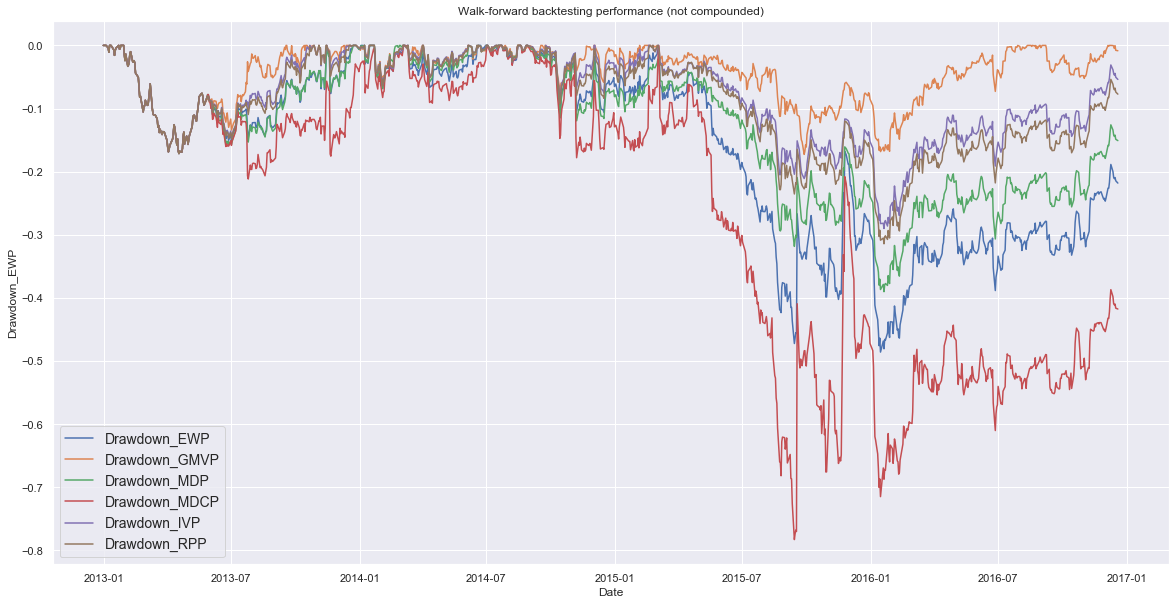

In [277]:
df_EWP = pd.DataFrame(EWP_backtest)
df_GMVP = pd.DataFrame(GMVP_backtest)
df_MDP = pd.DataFrame(MDP_backtest)
df_MDCP = pd.DataFrame(MDCP_backtest)
df_IVP = pd.DataFrame(IVP_backtest)
df_RPP = pd.DataFrame(RPP_backtest)

Roll_Max_EWP = df_EWP.cummax()
Roll_Max_GMVP = df_GMVP.cummax()
Roll_Max_MDP = df_MDP.cummax()
Roll_Max_MDCP = df_MDCP.cummax()
Roll_Max_IVP = df_IVP.cummax()
Roll_Max_RPP = df_RPP.cummax()

Daily_Drawdown_EWP = df_EWP/Roll_Max_EWP - 1.0
Daily_Drawdown_GMVP = df_GMVP/Roll_Max_GMVP - 1.0
Daily_Drawdown_MDP = df_MDP/Roll_Max_MDP - 1.0
Daily_Drawdown_MDCP = df_MDCP/Roll_Max_MDCP - 1.0
Daily_Drawdown_IVP = df_IVP/Roll_Max_IVP - 1.0
Daily_Drawdown_RPP = df_RPP/Roll_Max_RPP - 1.0

Max_Daily_Drawdown_EWP = Daily_Drawdown_EWP.cummin()
Max_Daily_Drawdown_GMVP = Daily_Drawdown_GMVP.cummin()
Max_Daily_Drawdown_MDP = Daily_Drawdown_MDP.cummin()
Max_Daily_Drawdown_MDCP = Daily_Drawdown_MDCP.cummin()
Max_Daily_Drawdown_IVP = Daily_Drawdown_IVP.cummin()
Max_Daily_Drawdown_RPP = Daily_Drawdown_RPP.cummin()


plt.figure(figsize=(20,10))
plt.plot(data.index, Daily_Drawdown_EWP, label='Drawdown_EWP')
plt.plot(data.index, Daily_Drawdown_GMVP, label='Drawdown_GMVP')
plt.plot(data.index, Daily_Drawdown_MDP, label='Drawdown_MDP')
plt.plot(data.index, Daily_Drawdown_MDCP, label='Drawdown_MDCP')
plt.plot(data.index, Daily_Drawdown_IVP, label='Drawdown_IVP')
plt.plot(data.index, Daily_Drawdown_RPP, label='Drawdown_RPP')

plt.legend(loc='lower left', fontsize=14)
plt.title('Walk-forward backtesting performance (not compounded)')
plt.xlabel('Date')
plt.ylabel('Drawdown_EWP')

Text(0, 0.5, 'Max_Drawdown_EWP')

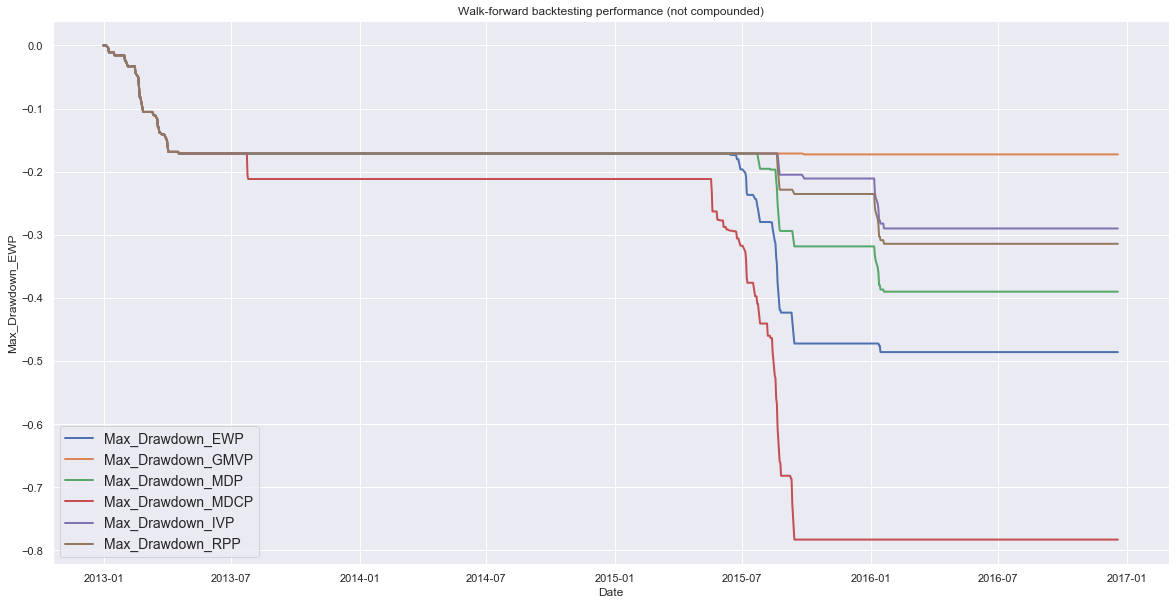

In [278]:
plt.figure(figsize=(20,10))
plt.plot(data.index, Max_Daily_Drawdown_EWP, lw=2, label='Max_Drawdown_EWP')
plt.plot(data.index, Max_Daily_Drawdown_GMVP, lw=2, label='Max_Drawdown_GMVP')
plt.plot(data.index, Max_Daily_Drawdown_MDP, lw=2, label='Max_Drawdown_MDP')
plt.plot(data.index, Max_Daily_Drawdown_MDCP, lw=2, label='Max_Drawdown_MDCP')
plt.plot(data.index, Max_Daily_Drawdown_IVP, lw=2, label='Max_Drawdown_IVP')
plt.plot(data.index, Max_Daily_Drawdown_RPP, lw=2, label='Max_Drawdown_RPP')

plt.legend(loc='lower left', fontsize=14)
plt.title('Walk-forward backtesting performance (not compounded)')
plt.xlabel('Date')
plt.ylabel('Max_Drawdown_EWP')

## (d) Implement a GARCH(1,1) model on the log-returns of the APD stock. In class, we have shown the usage of relevant R packages. In the problem, you have to find a Python package online, install it, and use it correctly by yourself. Plot the log-returns and the estimated volatility in one subplot:

In [279]:
from arch import arch_model

In [280]:
data_return_log

,AEZS,A,APD,AA,CF
Date,,,,,
2013-01-02,0.061119,0.022701,0.021663,0.035092,0.019883
2013-01-03,0.003945,0.003575,-0.003500,0.008859,-0.004740
2013-01-04,0.011742,0.019555,0.013351,0.020732,0.022152
2013-01-07,0.007752,-0.007259,-0.000923,-0.017430,-0.003753
2013-01-08,-0.015565,-0.008023,0.001845,0.000000,-0.014769
...,...,...,...,...,...
2016-12-13,-0.013072,0.005403,-0.003481,-0.032534,-0.020554
2016-12-14,0.000000,-0.005403,-0.006324,0.006920,-0.010616
2016-12-15,0.000000,0.009062,0.006122,-0.021913,0.019028


In [281]:
# define model
model = arch_model(data_return_log['APD'], vol='GARCH', p=1, q=1)

In [282]:
# fit model
model_fit = model.fit()

print(model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 369191348.4347133
Iteration:      2,   Func. Count:     18,   Neg. LLF: 142010.35111442851
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2784.554871062108
Iteration:      4,   Func. Count:     40,   Neg. LLF: 3015291.47930144
Iteration:      5,   Func. Count:     52,   Neg. LLF: 4314.481826586478
Iteration:      6,   Func. Count:     62,   Neg. LLF: 3369665.771576551
Iteration:      7,   Func. Count:     73,   Neg. LLF: 162190.5413602647
Iteration:      8,   Func. Count:     84,   Neg. LLF: 85190350373.96455
Iteration:      9,   Func. Count:     96,   Neg. LLF: 4263210065.3661537
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2966.0366464936933
            Iterations: 10
            Function evaluations: 105
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    APD   R-squared:           

/Users/kenneth/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001611. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/kenneth/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


<Figure size 1440x720 with 0 Axes>

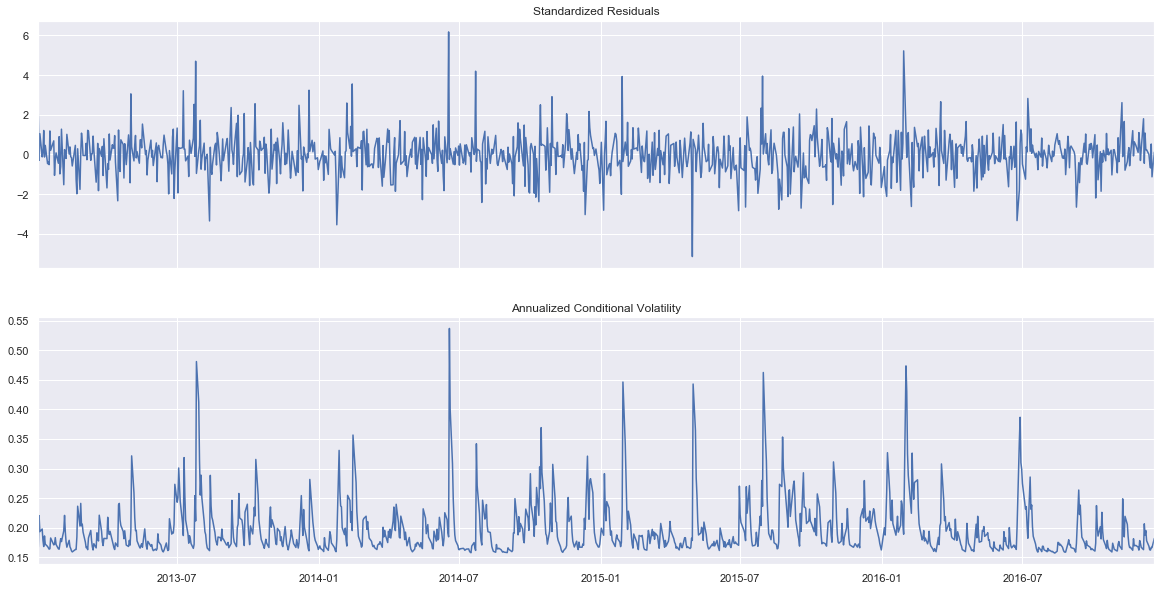

In [305]:
plt.figure(figsize=(20,10))
fig = model_fit.plot(annualize="D")

Text(0.5, 1.0, 'Envelope of APD based on GARCH(1,1)')

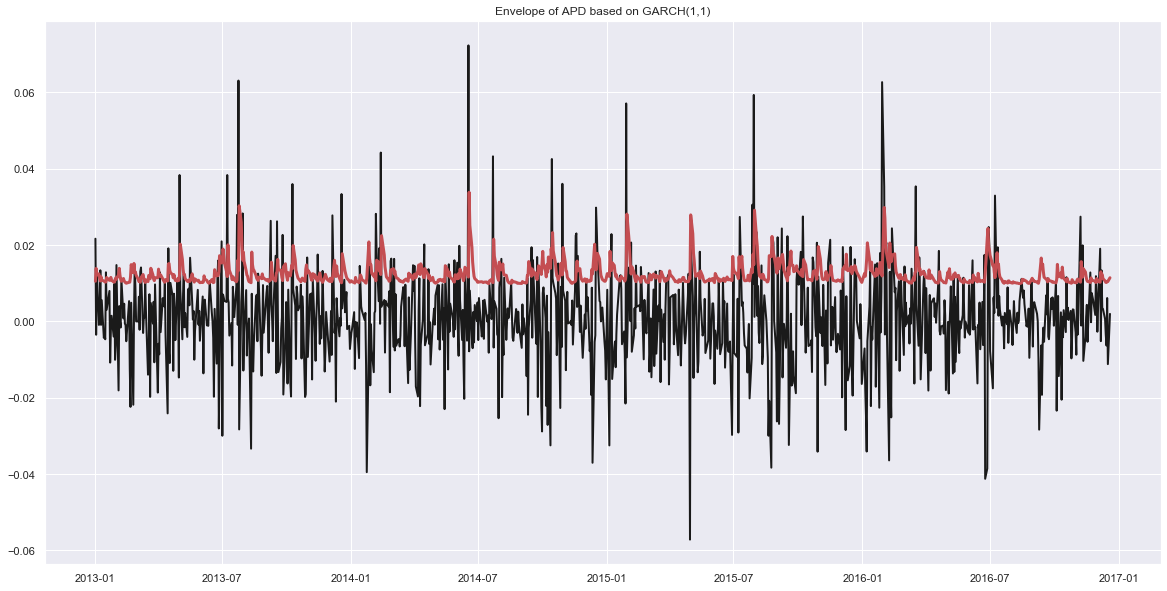

In [306]:
plt.figure(figsize=(20,10))
plt.plot(data_return_log['APD'], color='k', linewidth=2)
plt.plot(model_fit.conditional_volatility, color='r', linewidth=3)
plt.title('Envelope of APD based on GARCH(1,1)')

# Problem 2: Time Series Modeling (50 points)

In [285]:
# set display options
pd.options.display.max_rows, pd.options.display.max_columns = 10, 25
data = pd.read_csv('midterm_us_retail_employment.csv')
data['month'] = pd.to_datetime(data.month)
data = data.set_index('month')
data.drop(columns='Unnamed: 0',inplace=True)
data.dropna(inplace = True)
data

,employed,type
month,,
1990-01-01,13255.8,train
1990-02-01,12966.3,train
1990-03-01,12938.2,train
1990-04-01,13012.3,train
1990-05-01,13108.3,train
...,...,...
2018-08-01,15834.9,test
2018-09-01,15680.6,test
2018-10-01,15796.5,test


Text(0.5, 1.0, 'All_data')

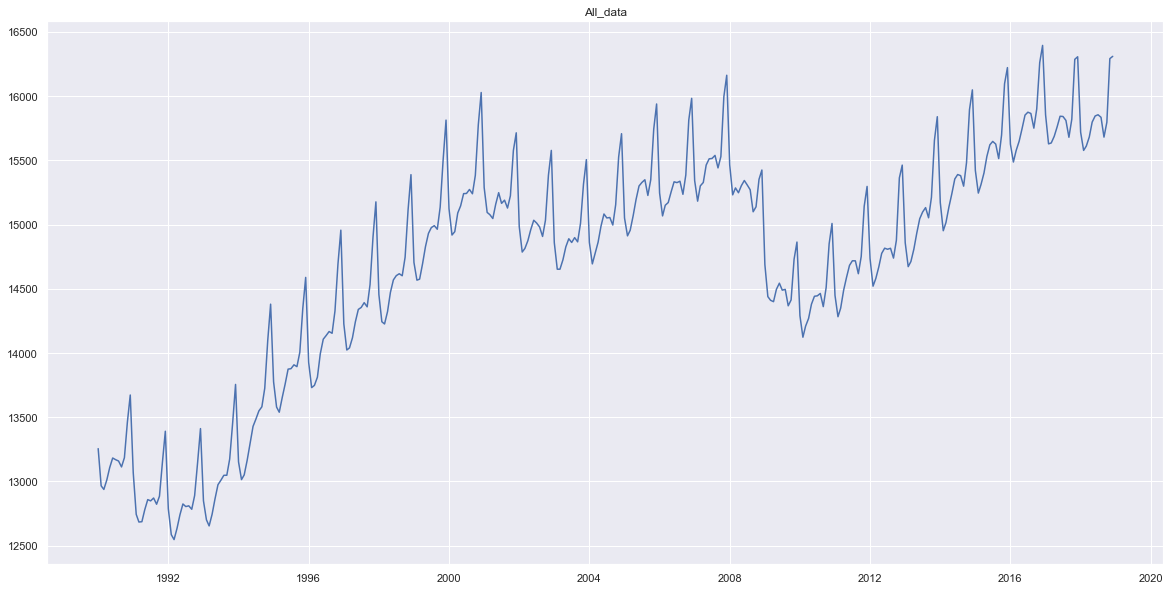

In [286]:
plt.figure(figsize=(20,10))
plt.plot(data.index,data['employed'])
plt.title('All_data')

In [287]:
data_train = data[data['type'] == 'train']
data_train

,employed,type
month,,
1990-01-01,13255.8,train
1990-02-01,12966.3,train
1990-03-01,12938.2,train
1990-04-01,13012.3,train
1990-05-01,13108.3,train
...,...,...
2013-08-01,15131.7,train
2013-09-01,15052.6,train
2013-10-01,15212.3,train


Text(0.5, 1.0, 'Train_data')

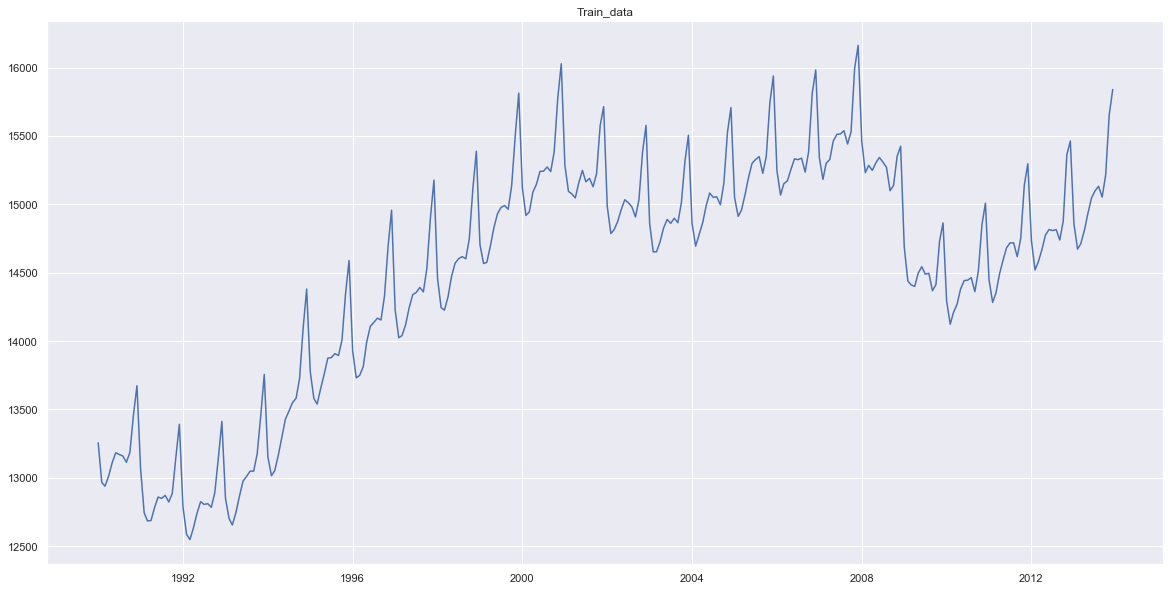

In [288]:
plt.figure(figsize=(20,10))
plt.plot(data_train.index,data_train['employed'])
plt.title('Train_data')

In [289]:
data_test = data[data['type'] == 'test']
data_test

,employed,type
month,,
2014-01-01,15170.7,test
2014-02-01,14951.8,test
2014-03-01,15015.4,test
2014-04-01,15137.0,test
2014-05-01,15238.9,test
...,...,...
2018-08-01,15834.9,test
2018-09-01,15680.6,test
2018-10-01,15796.5,test


Text(0.5, 1.0, 'Test_data')

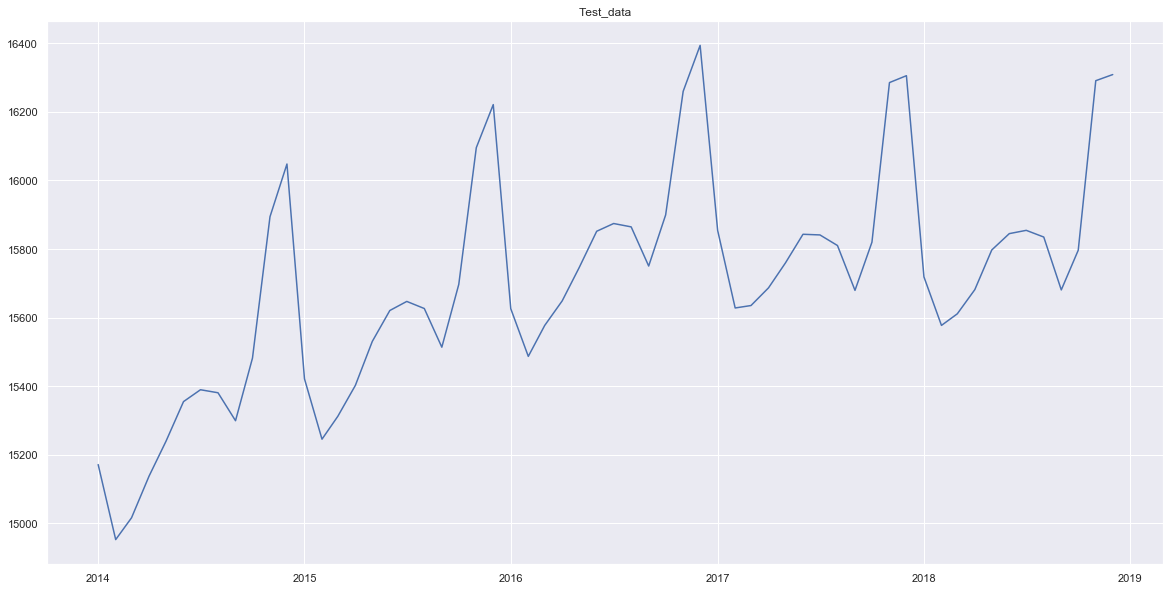

In [290]:
plt.figure(figsize=(20,10))
plt.plot(data_test.index,data_test['employed'])
plt.title('Test_data')

## (a) Multiplicative decomposition

In [291]:
data_train['ma'] = data_train.loc[:,'employed'].rolling(window=12).mean()
data_train

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employed,type,ma
month,,,
1990-01-01,13255.8,train,NaN
1990-02-01,12966.3,train,NaN
1990-03-01,12938.2,train,NaN
1990-04-01,13012.3,train,NaN
1990-05-01,13108.3,train,NaN
...,...,...,...
2013-08-01,15131.7,train,14974.950000
2013-09-01,15052.6,train,15001.091667
2013-10-01,15212.3,train,15028.975000


/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Moving Average of employed on train data')

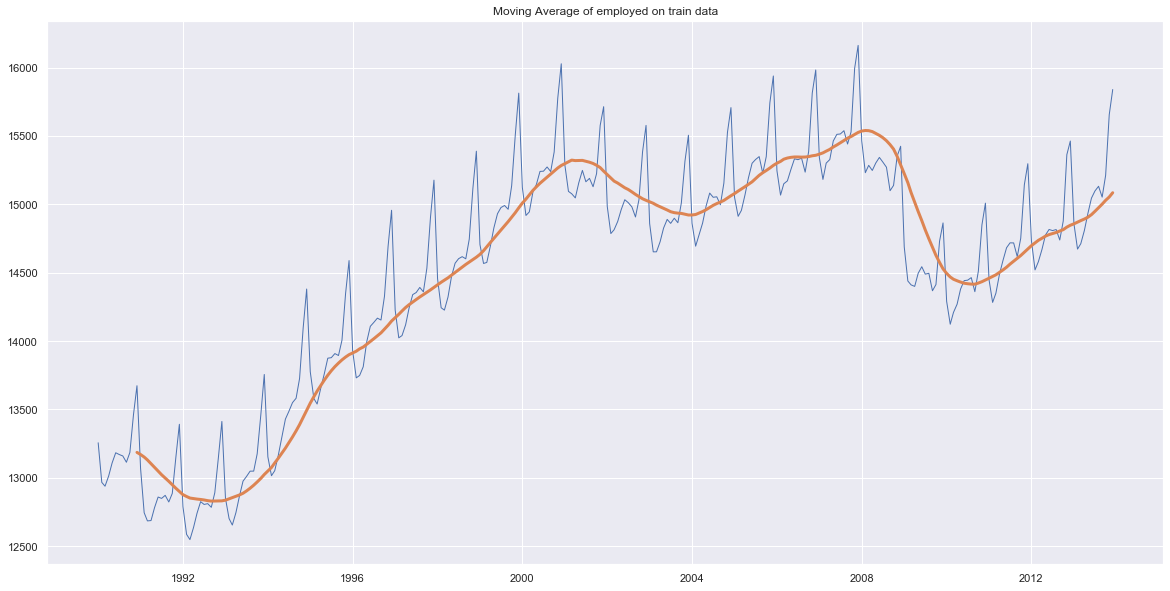

In [292]:
window_length = 12
data_train['ma'] = data_train.loc[:,'employed'].rolling(window=window_length).mean()


plt.figure(figsize=(20,10))
plt.plot(data_train['employed'], linewidth=1, alpha=1)
plt.plot(data_train['ma'], linewidth=3,  alpha=1)

plt.title('Moving Average of employed on train data')

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1, 'detrended signal')

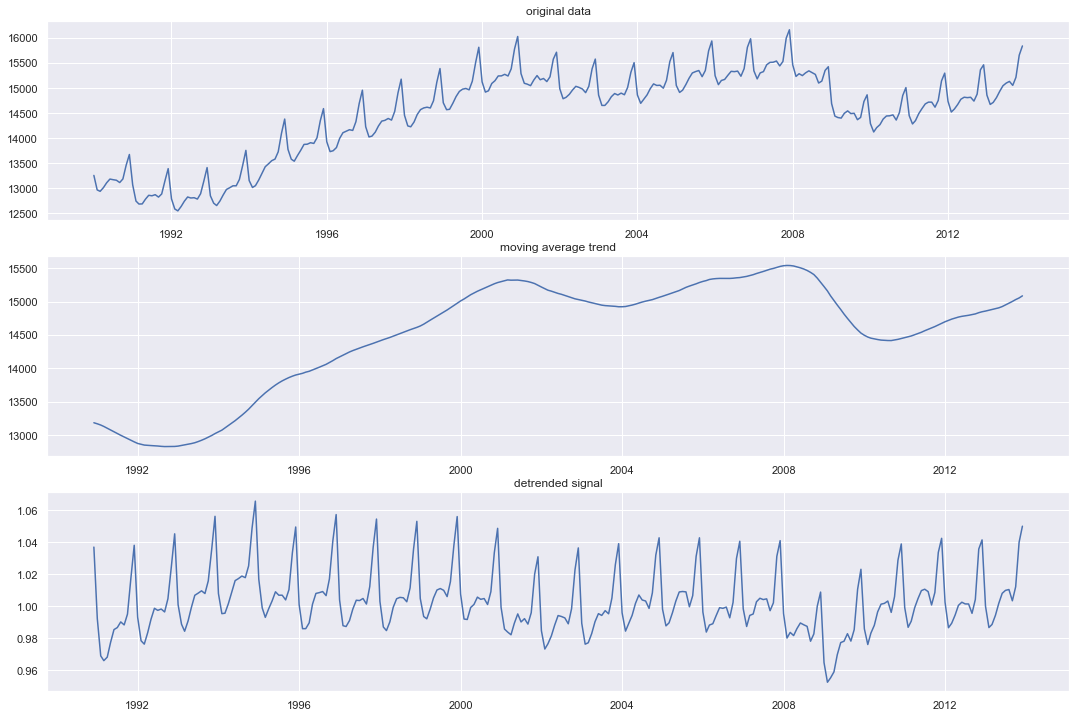

In [879]:
data_train['detrended'] = data_train['employed'] / data_train['ma']

fig, ax = plt.subplots(3, 1, figsize=(15,10))
fig.tight_layout()
ax[0].plot(data_train['employed'])
ax[0].set_title("original data")
ax[1].plot(data_train['ma'])
ax[1].set_title("moving average trend")
ax[2].plot(data_train['detrended'])
ax[2].set_title("detrended signal")

In [880]:
data_train

,employed,type,ma,detrended
month,,,,
1990-01-01,13255.8,train,NaN,NaN
1990-02-01,12966.3,train,NaN,NaN
1990-03-01,12938.2,train,NaN,NaN
1990-04-01,13012.3,train,NaN,NaN
1990-05-01,13108.3,train,NaN,NaN
...,...,...,...,...
2013-08-01,15131.7,train,14974.950000,1.010467
2013-09-01,15052.6,train,15001.091667,1.003434
2013-10-01,15212.3,train,15028.975000,1.012198


/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/kenneth/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kenneth/anaconda3/lib/py

Text(0.5, 1, 'residual')

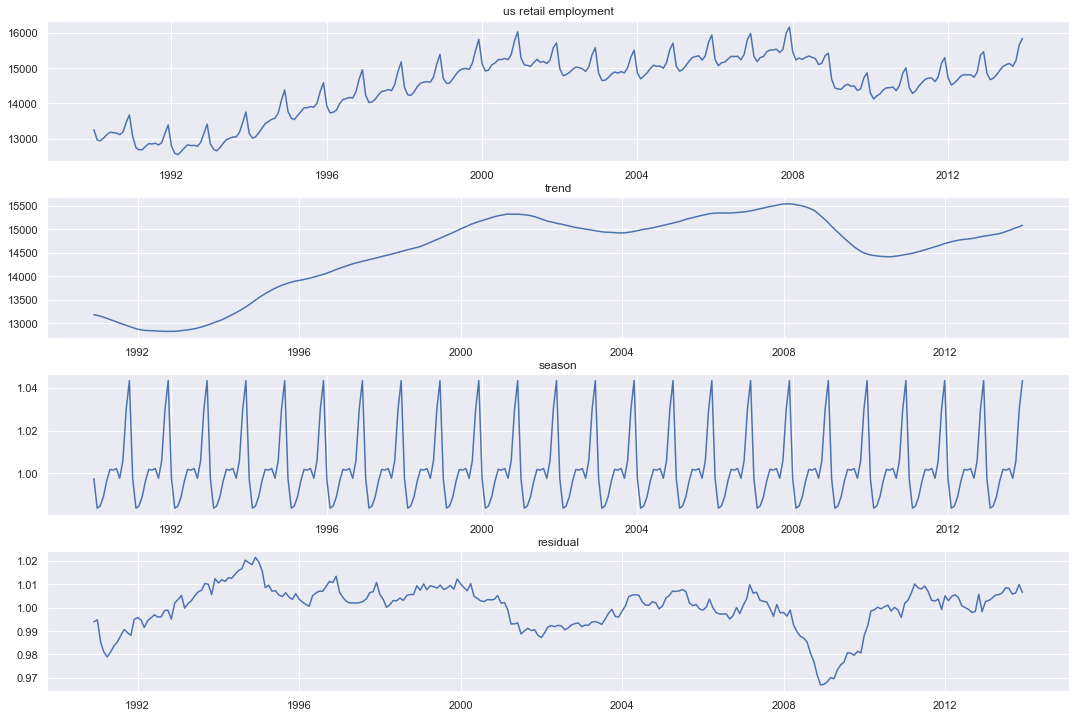

In [881]:
for i in range(window_length):
    idx = np.arange(i, len(data_train), window_length).astype(np.int)
    data_train.loc[data_train.index[idx], 'seasonal'] = np.mean(data_train.loc[data_train.index[idx], 'detrended'])

data_train['residual'] = data_train['detrended'] / data_train['seasonal']

fig, ax = plt.subplots(4, 1, figsize=(15,10))
fig.tight_layout() 
ax[0].plot(data_train['employed'])
ax[0].set_title("us retail employment")
ax[1].plot(data_train['ma'])
ax[1].set_title("trend")
ax[2].plot(data_train['seasonal'])
ax[2].set_title("season")
ax[3].plot(data_train['residual'])
ax[3].set_title("residual")

In [882]:
data_train['residual'].mean()

1.0000000000000007

## (b) Fit an AR model on training data

In [883]:
data_train

,employed,type,ma,detrended,seasonal,residual
month,,,,,,
1990-01-01,13255.8,train,NaN,NaN,0.997496,NaN
1990-02-01,12966.3,train,NaN,NaN,0.983709,NaN
1990-03-01,12938.2,train,NaN,NaN,0.984689,NaN
1990-04-01,13012.3,train,NaN,NaN,0.989108,NaN
1990-05-01,13108.3,train,NaN,NaN,0.996316,NaN
...,...,...,...,...,...,...
2013-08-01,15131.7,train,14974.950000,1.010467,1.002242,1.008207
2013-09-01,15052.6,train,15001.091667,1.003434,0.997690,1.005757
2013-10-01,15212.3,train,15028.975000,1.012198,1.005886,1.006276


In [884]:
import cvxpy as cp
import numpy as np

T = len(data_train['ma'].shift(periods=2).dropna().values)

# define variable
a = cp.Variable()
b = cp.Variable()
c = cp.Variable()

ground_value = data_train['ma'].values[-T:]
lag_1 = data_train['ma'].shift(periods=1).values[-T:]
lag_2 = data_train['ma'].shift(periods=2).values[-T:]
# define objective
objective = cp.Minimize(cp.sum_squares(ground_value - a * lag_1 - b * lag_2 - c))
# create problem
prob = cp.Problem(objective)
# solve it!
result = prob.solve()
a = a.value
b = b.value
c = c.value
print('a: ', a)
print('b: ', b)
print('c: ', c)

a:  1.9822790577973965
b:  -0.9832808840383873
c:  14.827830152964987


## (c) Test process

In [885]:
data_train

,employed,type,ma,detrended,seasonal,residual
month,,,,,,
1990-01-01,13255.8,train,NaN,NaN,0.997496,NaN
1990-02-01,12966.3,train,NaN,NaN,0.983709,NaN
1990-03-01,12938.2,train,NaN,NaN,0.984689,NaN
1990-04-01,13012.3,train,NaN,NaN,0.989108,NaN
1990-05-01,13108.3,train,NaN,NaN,0.996316,NaN
...,...,...,...,...,...,...
2013-08-01,15131.7,train,14974.950000,1.010467,1.002242,1.008207
2013-09-01,15052.6,train,15001.091667,1.003434,0.997690,1.005757
2013-10-01,15212.3,train,15028.975000,1.012198,1.005886,1.006276


In [886]:
data_test

,employed,type
month,,
2014-01-01,15170.7,test
2014-02-01,14951.8,test
2014-03-01,15015.4,test
2014-04-01,15137.0,test
2014-05-01,15238.9,test
...,...,...
2018-08-01,15834.9,test
2018-09-01,15680.6,test
2018-10-01,15796.5,test


In [887]:
data_test['seasonal'] = data_train['seasonal'][:len(data_test)].values
data_test['residual'] = 1

data_test

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employed,type,seasonal,residual
month,,,,
2014-01-01,15170.7,test,0.997496,1
2014-02-01,14951.8,test,0.983709,1
2014-03-01,15015.4,test,0.984689,1
2014-04-01,15137.0,test,0.989108,1
2014-05-01,15238.9,test,0.996316,1
...,...,...,...,...
2018-08-01,15834.9,test,1.002242,1
2018-09-01,15680.6,test,0.997690,1
2018-10-01,15796.5,test,1.005886,1


In [888]:
data_test.loc[data_test.index[0],'trend_AR2'] = a * data_train.loc[data_train.index[-1], 'ma'] + b * data_train.loc[data_train.index[-2], 'ma'] + c
data_test.loc[data_test.index[1],'trend_AR2'] = a * data_test.loc[data_test.index[0], 'trend_AR2'] + b * data_train.loc[data_train.index[-1], 'ma'] + c

for i in range(2, len(data_test)):
    lag_1 = data_test.loc[data_test.index[i-1],'trend_AR2']
    lag_2 = data_test.loc[data_test.index[i-2],'trend_AR2']
    data_test.loc[data_test.index[i],'trend_AR2'] = a * lag_1 + b * lag_2 + c
    
data_test

,employed,type,seasonal,residual,trend_AR2
month,,,,,
2014-01-01,15170.7,test,0.997496,1,15115.340421
2014-02-01,14951.8,test,0.983709,1,15145.112476
2014-03-01,15015.4,test,0.984689,1,15174.041828
2014-04-01,15137.0,test,0.989108,1,15202.113583
2014-05-01,15238.9,test,0.996316,1,15229.313958
...,...,...,...,...,...
2018-08-01,15834.9,test,1.002242,1,15447.640315
2018-09-01,15680.6,test,0.997690,1,15433.590159
2018-10-01,15796.5,test,1.005886,1,15419.140963


Text(0.5, 1, 'residual')

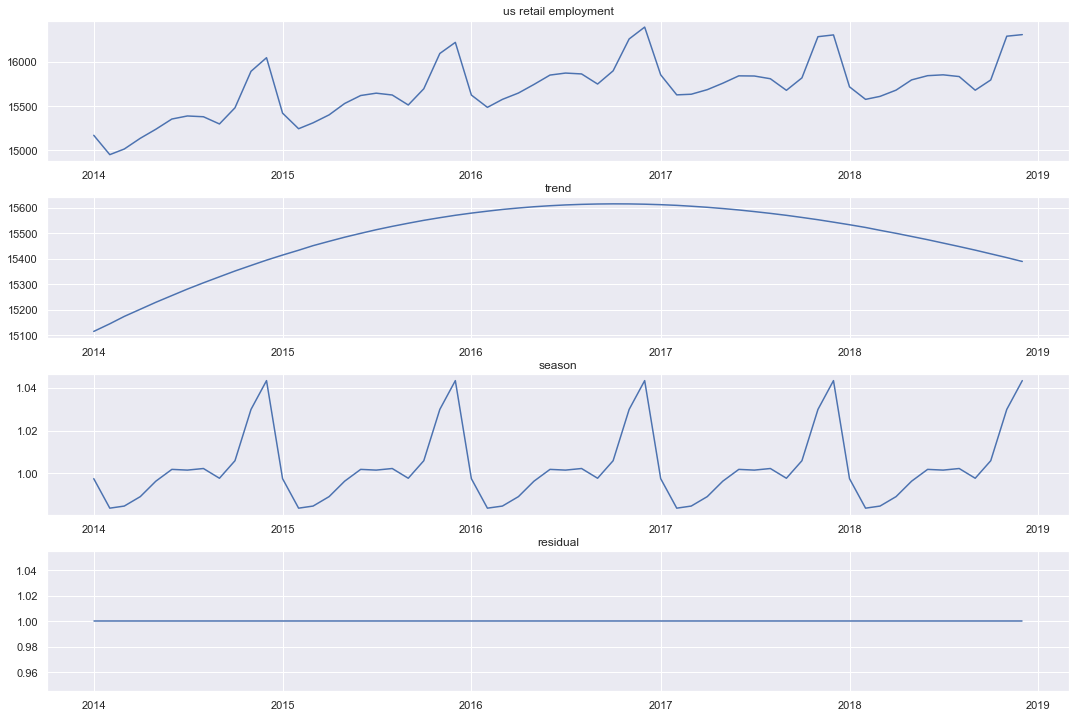

In [889]:
fig, ax = plt.subplots(4, 1, figsize=(15,10))
fig.tight_layout() 
ax[0].plot(data_test['employed'])
ax[0].set_title("us retail employment")
ax[1].plot(data_test['trend_AR2'])
ax[1].set_title("trend")
ax[2].plot(data_test['seasonal'])
ax[2].set_title("season")
ax[3].plot(data_test['residual'])
ax[3].set_title("residual")

In [890]:
data

,employed,type
month,,
1990-01-01,13255.8,train
1990-02-01,12966.3,train
1990-03-01,12938.2,train
1990-04-01,13012.3,train
1990-05-01,13108.3,train
...,...,...
2018-08-01,15834.9,test
2018-09-01,15680.6,test
2018-10-01,15796.5,test


In [891]:
window_length = 12
data['ma'] = data.loc[:,'employed'].rolling(window=window_length).mean()

Text(0.5, 1.0, 'Trend prediction on test data')

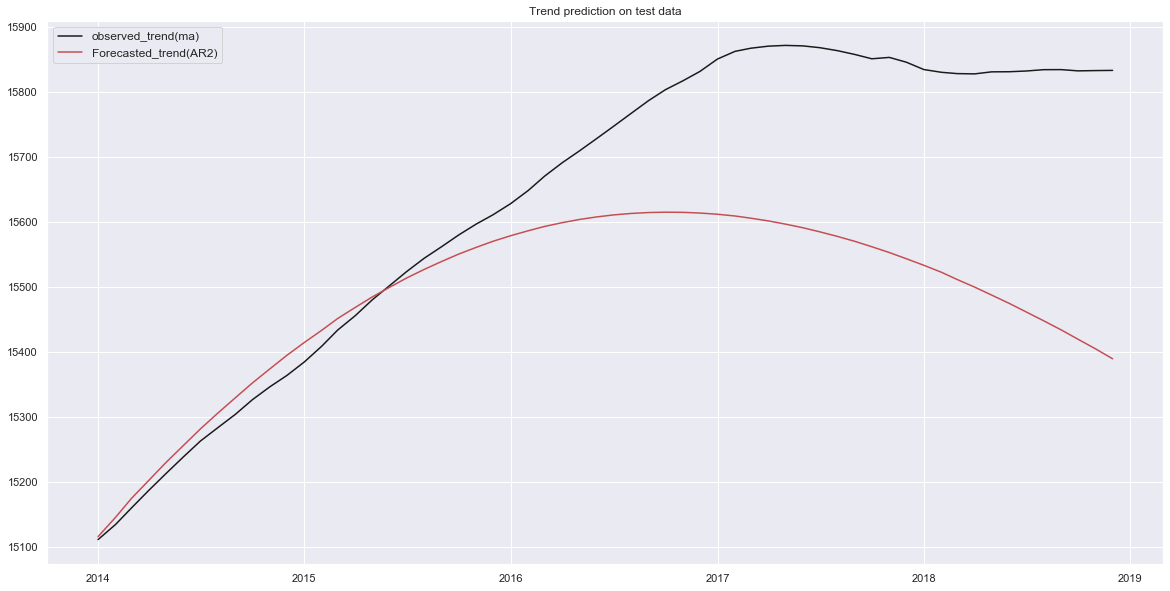

In [892]:
plt.plot(data['ma'][-len(data_test):], label='observed_trend(ma)', color='k')
plt.plot(data_test['trend_AR2'], label='Forecasted_trend(AR2)', color='r')
plt.legend(loc='upper left', fontsize=12)
plt.title('Trend prediction on test data')

In [893]:
data_test['predicted_employed'] = data_test['trend_AR2'] * data_test['seasonal'] * data_test['residual']
data_test

/Users/kenneth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employed,type,seasonal,residual,trend_AR2,predicted_employed
month,,,,,,
2014-01-01,15170.7,test,0.997496,1,15115.340421,15077.498772
2014-02-01,14951.8,test,0.983709,1,15145.112476,14898.389513
2014-03-01,15015.4,test,0.984689,1,15174.041828,14941.718045
2014-04-01,15137.0,test,0.989108,1,15202.113583,15036.533480
2014-05-01,15238.9,test,0.996316,1,15229.313958,15173.212538
...,...,...,...,...,...,...
2018-08-01,15834.9,test,1.002242,1,15447.640315,15482.271978
2018-09-01,15680.6,test,0.997690,1,15433.590159,15397.936076
2018-10-01,15796.5,test,1.005886,1,15419.140963,15509.891570


Text(0.5, 1.0, 'US retail employment training and prediction')

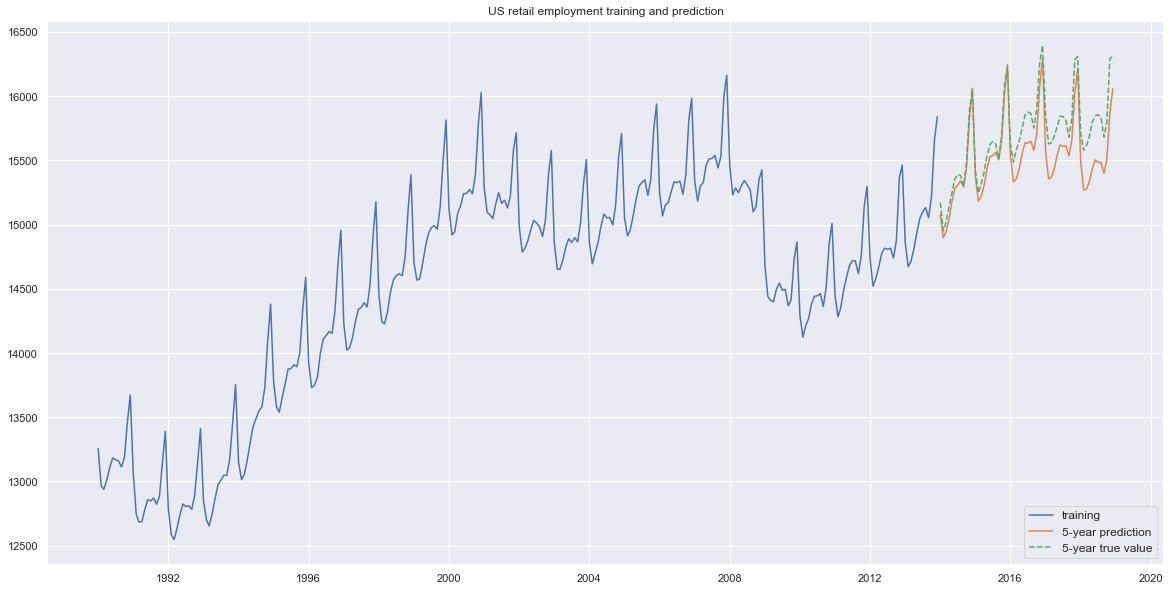

In [894]:
plt.plot(data_train['employed'], label='training')
plt.plot(data_test['predicted_employed'], label='5-year prediction', ls='-')
plt.plot(data_test['employed'], label='5-year true value', ls='--')
plt.legend(loc='lower right', fontsize=12)
plt.title('US retail employment training and prediction')